# Project: Analysis data from yandex realty

In [ ]:
from time import sleep
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from time import sleep
import random
import matplotlib.pyplot as plt

### Collect references to cards

Usual main page:

![image.png](attachment:701ea618-8ab4-4c4e-a4f1-6c749c4c4c21.png)


As you can see we have several pages and each page contains about 20 links to card.

First step is to collect enough urls to cards.
For that we iterage across pages (maximum 20) with different filters: 'by defualt', 'novostroiki', 'vtorichniy-rynok', 'recent' and collect all of them to file 'references.txt'

In [ ]:
br = webdriver.Chrome()
with open('references.txt', 'w') as file:
    for i in range(1,20):
        base_url = 'https://realty.yandex.ru/moskva/kupit/kvartira/?sort=DATE_DESC&page='
        br.get(base_url + str(i))
        soup = BeautifulSoup(br.page_source)
        a_s = soup.find_all('a', {'class': 'OffersSerpItem__titleLink'})
        for a in a_s:
            file.write(a['href'] + '\n')
        sleep(random.randint(2, 5))
br.close()

In [ ]:
br = webdriver.Chrome()
with open('references.txt', 'a') as file:
    for i in range(1,20):
        base_url = 'https://realty.yandex.ru/moskva/kupit/kvartira/?&page='
        br.get(base_url + str(i))
        soup = BeautifulSoup(br.page_source)
        a_s = soup.find_all('a', {'class': 'OffersSerpItem__titleLink'})
        for a in a_s:
            file.write(a['href'] + '\n')
        sleep(random.randint(2, 5))
br.close()


In [ ]:
br = webdriver.Chrome()
with open('references.txt', 'a') as file:
    for i in range(1,20):
        base_url = 'https://realty.yandex.ru/moskva/kupit/kvartira/novostroyki/?&page='
        br.get(base_url + str(i))
        soup = BeautifulSoup(br.page_source)
        a_s = soup.find_all('a', {'class': 'OffersSerpItem__titleLink'})
        for a in a_s:
            file.write(a['href'] + '\n')
        sleep(random.randint(2, 5))
br.close()


In [ ]:
br = webdriver.Chrome()
with open('references.txt', 'a') as file:
    for i in range(1,20):
        base_url = 'https://realty.yandex.ru/moskva/kupit/kvartira/vtorichniy-rynok/?&page='
        br.get(base_url + str(i))
        soup = BeautifulSoup(br.page_source)
        a_s = soup.find_all('a', {'class': 'OffersSerpItem__titleLink'})
        for a in a_s:
            file.write(a['href'] + '\n')
        sleep(random.randint(2, 5))
br.close()


In [ ]:
total = set()
with open('references.txt', 'r') as file:
    for line in file:
        total.add(line)
print(len(total))

1383


Total collected number without duplicates is 1383.

Let's write them into separate file

In [ ]:
with open('references_to_process.txt', 'w') as file:
    for line in total:
        file.write(line)

The next method extracts all necessary data from a page.

Let's consider usual card:

![Screenshot 2024-11-28 225805.png](attachment:79486717-4e74-4d84-b51f-5eebb88b15dc.png)

It contains information about a flat (OfferCardHighlight), about building (OfferCardFeature), description with price and information about transport availability

In [ ]:
def get_values(text):
    soup = BeautifulSoup(text)
    divs = soup.find_all('div', recursive=True)
    values = {}
    values['id'] = url_card
    for div in divs:
        if div.has_attr('class') and 'OfferCardHighlight' in str(div['class']):
            key = None
            value = None
            key_values = div.find_all('div', recursive=True)
            for k_v in key_values:
                if k_v.has_attr('class') and 'OfferCardHighlight__label'  in  str(k_v['class']):
                    key = k_v.text
                if k_v.has_attr('class') and 'OfferCardHighlight__value' in str( k_v['class']):
                    value = k_v.text
            if key is not None and value is not None:
                if 'из' in key and 'этаж' in value:
                    values['floor'] =  value
                    values['total_floors'] = key
                else:
                    values[key] = value
        if div.has_attr('class') and 'OfferCardFeature' in str(div['class']):
            if div.has_attr('title') and 'Застройщик' in str(div['title']):
                values['Застройщик'] = div.text
            if div.has_attr('title') and 'здание' in str(div['title']):
                values['здание'] = div.text
            if div.has_attr('title') and 'парковка' in str(div['title']):
                values['парковка'] = div.text
            if div.has_attr('title') and 'Лифт' in str(div['title']):
                values['Лифт'] = div.text
    h1s = soup.find_all('h1', recursive=True)
    for h1 in h1s:
        if h1.has_attr('class') and 'OfferCardSummaryInfo__description' in str(h1['class']):
             values['description'] = h1.text
    spans = soup.find_all('span', recursive=True)
    for span in spans:
        if span.has_attr('class') and 'OfferCardSummaryInfo__price' in str(span['class']):
             values['price'] = span.text
        if span.has_attr('class') and 'MetroStation__title' in str(span['class']):
             values['metro'] = span.text
        if span.has_attr('class') and 'CardLocation__stationDistance' in str(span['class']):
             insides = span.find_all('span')
             for inside in insides:
                 if 'мин' in inside.text:
                     values['distance']=inside.text
             insides = span.find_all('i')

             for inside in insides:
                if inside.has_attr('class') and '-bus' in str(inside['class']):
                    values['how_distance'] = 'transport'
    return values

Now let's process each url separately, processed.txt is used not to process url twice. Data is serialized as json line by line and will be processed later

In [ ]:
import json

br = webdriver.Chrome()

base_references_url = 'https://realty.yandex.ru'
processed = set()
with open('processed.txt', 'r') as processed_file:
    for line in processed_file:
        processed.add(line)
with open('references_to_process.txt', 'r') as from_file:
    with open('db.txt', 'a', encoding='utf-8') as out_file:
        with open('processed.txt', 'a') as processed_file:
            for line in from_file:
                if line in processed:
                    continue

                url_card = line

                br.get(base_references_url + url_card)
                values = get_values(br.page_source)
                print('processed ' + line)
                if len(values)==0:
                    continue
                new_line = json.dumps(values, ensure_ascii=False) + '\n'
                out_file.write(new_line)
                processed_file.write(line)
                sleep(random.randint(2, 5))


processed /offer/6249958057991465083/

processed /offer/1172104348281000672/

processed /offer/5180127926972063871/

processed /offer/2750569904679395363/

processed /offer/4017216401161943161/

processed /offer/7200141999400450171/

processed /offer/5865261779009023695/

processed /offer/3966239452083846598/

processed /offer/2750569904678466940/

processed /offer/6247499171502263710/

processed /offer/2750569904679396259/

processed /offer/5226925891342870686/

processed /offer/7770332115910998511/

processed /offer/9189174884320017765/

processed /offer/3960449229825563729/

processed /offer/6684252019320101632/

processed /offer/7185624840235312301/

processed /offer/8277721983992880825/

processed /offer/7609190865851852014/

processed /offer/5227565616455321670/

processed /offer/4362772936353501502/

processed /offer/4043229870950118379/

processed /offer/7948406867420830140/

processed /offer/3392378183309832798/

processed /offer/2750569743833432195/

processed /offer/62729392

Let's check columns

In [ ]:
keys = set()
with open('db.txt', 'r', encoding='utf-8') as file:
    for line in file:
        data = json.loads(line)
        keys.update(data.keys())
print(keys)

{'total_floors', 'distance', 'парковка', 'id', 'Лифт', 'здание', 'metro', 'год постройки', 'floor', 'срок сдачи', 'потолки', 'общая', 'Застройщик', 'жилая', 'description', 'кухня', 'how_distance', 'price'}


Let's create data frame from data

In [ ]:
output = pd.DataFrame()
with open('db.txt', 'r', encoding='utf-8') as file:
    for line in file:
        data = json.loads(line)
        df_dictionary = pd.DataFrame([data])
        output = pd.concat([output, df_dictionary], ignore_index=True)

output.head(10)

,id,срок сдачи,общая,жилая,кухня,floor,total_floors,потолки,Застройщик,здание,Лифт,парковка,description,price,metro,distance,год постройки,how_distance
0,/offer/6328777127894859155/\n,2024 год,"54,9 м²","33,4 м²","6,7 м²",16 этаж,из 18,"3,14 м",Застройщик ГК «А101»,Монолитное здание,Лифт,Открытая парковка,"54,9 м², 3-комнатная квартира",20 464 170 ₽,Ольховая,19 мин.,NaN,NaN
1,/offer/6249958057991401381/\n,NaN,"40,5 м²","19,3 м²","10,5 м²",14 этаж,из 22,NaN,Застройщик ГК ФСК,NaN,NaN,Открытая парковка,"40,5 м², 1-комнатная квартира",8 500 000 ₽,Химки,19 мин.,2016 год,transport
2,/offer/4436300590218059257/\n,2026 год,"65,5 м²",NaN,NaN,7 этаж,из 22,NaN,"Застройщики ГК «Развитие», ГлавГрадоСтрой",NaN,NaN,Открытая парковка,"65,5 м², 2-комнатная квартира",10 090 236 ₽,Бутово,21 мин.,NaN,transport
3,/offer/7732108553124534775/\n,NaN,57 м²,"20,1 м²","22,1 м²",5 этаж,из 8,4 м,Застройщик ПАТЕК ГРУПП,NaN,Лифт,Открытая парковка,"57 м², 2-комнатные апартаменты",,Бутырская,14 мин.,2024 год,NaN
4,/offer/2316491653782316494/\n,2025 год,94 м²,"35,9 м²","16,2 м²",6 этаж,из 13,"3,6 м",Застройщик MR Group,Кирпично-монолитное здание,Лифт,Открытая парковка,"94 м², 2-комнатная квартира",154 606 496 ₽,Проспект Мира,6 мин.,NaN,NaN
5,/offer/6799954518335051987/\n,NaN,"56,2 м²","33,7 м²","12,9 м²",17 этаж,из 17,"2,64 м",NaN,Панельное здание,Лифт,Открытая парковка,"56,2 м², 2-комнатная квартира",19 500 000 ₽,Кунцевская,5 мин.,1984 год,NaN
6,/offer/6249958057991465083/\n,NaN,"44,1 м²",NaN,"4,2 м²",23 этаж,из 23,"2,7 м",Застройщик ПИК,Монолитное здание,Лифт,Открытая парковка,"44,1 м², 2-комнатная квартира",9 600 000 ₽,Планерная,28 мин.,2018 год,transport
7,/offer/1172104348281000672/\n,2025 год,"62,2 м²","30,9 м²","22,4 м²",5 этаж,из 26,"2,85 м",Застройщик РГ-Девелопмент,Монолитное здание,Лифт,Подземная парковка,"62,2 м², 2-комнатная квартира",20 367 576 ₽,Измайлово,17 мин.,NaN,NaN
8,/offer/5180127926972063871/\n,NaN,"24,1 м²","9,4 м²",NaN,3 этаж,из 23,"2,8 м",Застройщик 1-й ДСК,Панельное здание,Лифт,Открытая парковка,"24,1 м², квартира-студия",6 200 000 ₽,Бутово,26 мин.,2024 год,transport
9,/offer/2750569904679395363/\n,NaN,"111,9 м²",77 м²,11 м²,3 этаж,из 16,"2,75 м",NaN,Панельное здание,Лифт,Закрытая парковка,"111,9 м², 5-комнатная квартира",28 000 000 ₽,Шипиловская,4 мин.,1996 год,NaN


In [ ]:
df_obj = output.select_dtypes('object')
output[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
output.to_csv('db.csv', sep='\t', encoding='utf-8')

### Preprocessing and creation of basic features

In [ ]:
!gdown 1XeER9b8h46R3cUAxoPNjn4KWTiRit6tw
!gdown 1Hyj3NtgQd8ZdvIzcs5zQiWvmF2nKLgBF
!gdown 1cs7-DCpCw5b72JgxeCEHopa49WMLdBRA
!gdown 1lpUBCHkRUS5V9ewBiCiyQkRJVibb5pmx
!gdown 1hVUPeFPXSfSDLptYHuaaT59D3nk5Czd0
!gdown 1G5JvpH8wcDMPAYpjhruH5_k4HdUazi_n
!gdown 1xI8X9LRIzNrFtdJyl0OOmB03D1ywfYN7
!gdown 1SzzmK9COQbbgX4q6yfsi0JjQxE_DINjJ
!gdown 1Bcvtx-zvX6jt3peqRDlghnVJVxy_CmYQ
!gdown 1Pohy5yXKctMqK5rFuKANVJcEzr_Hcfcf
!gdown 1WllmeOxY4tSgLhckBUWlotcTnJqJTZL8
!gdown 1keyXyWjGOBfH1xwUaXzy3SQcfziNqKZ7

Downloading...
From: https://drive.google.com/uc?id=1XeER9b8h46R3cUAxoPNjn4KWTiRit6tw
To: /content/data.csv
100% 343k/343k [00:00<00:00, 43.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Hyj3NtgQd8ZdvIzcs5zQiWvmF2nKLgBF
To: /content/db.csv
100% 408k/408k [00:00<00:00, 82.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cs7-DCpCw5b72JgxeCEHopa49WMLdBRA
To: /content/ЗАО.txt
100% 1.53k/1.53k [00:00<00:00, 4.40MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lpUBCHkRUS5V9ewBiCiyQkRJVibb5pmx
To: /content/Отдельный.txt
100% 559/559 [00:00<00:00, 2.56MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hVUPeFPXSfSDLptYHuaaT59D3nk5Czd0
To: /content/САО.txt
100% 1.34k/1.34k [00:00<00:00, 4.52MB/s]
Downloading...
From: https://drive.google.com/uc?id=1G5JvpH8wcDMPAYpjhruH5_k4HdUazi_n
To: /content/СВАО.txt
100% 974/974 [00:00<00:00, 3.27MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xI8X9LRIzNrFtdJyl0OOmB03D1ywfYN7
To: /content/СЗАО.txt
100% 512/

Let's load and rename columns and see what we have

In [ ]:
import pandas as pd

df = pd.read_csv('db.csv', sep='\t', encoding='utf-8', index_col=0)
df = df.set_axis(['id', 'will_year', 'all_m2', 'living_m2','kitchen_m2', 'floor_number', 'total_floor_number', 'ceiling_m', 'builder', 'type_building', 'lift', 'parking', 'description', 'price_r', 'metro', 'distance_min', 'was_year', 'how_distance'], axis=1)
df.head()

,id,will_year,all_m2,living_m2,kitchen_m2,floor_number,total_floor_number,ceiling_m,builder,type_building,lift,parking,description,price_r,metro,distance_min,was_year,how_distance
0,/offer/6328777127894859155/,2024 год,"54,9 м²","33,4 м²","6,7 м²",16 этаж,из 18,"3,14 м",Застройщик ГК «А101»,Монолитное здание,Лифт,Открытая парковка,"54,9 м², 3-комнатная квартира",20 464 170 ₽,Ольховая,19 мин.,NaN,NaN
1,/offer/6249958057991401381/,NaN,"40,5 м²","19,3 м²","10,5 м²",14 этаж,из 22,NaN,Застройщик ГК ФСК,NaN,NaN,Открытая парковка,"40,5 м², 1-комнатная квартира",8 500 000 ₽,Химки,19 мин.,2016 год,transport
2,/offer/4436300590218059257/,2026 год,"65,5 м²",NaN,NaN,7 этаж,из 22,NaN,"Застройщики ГК «Развитие», ГлавГрадоСтрой",NaN,NaN,Открытая парковка,"65,5 м², 2-комнатная квартира",10 090 236 ₽,Бутово,21 мин.,NaN,transport
3,/offer/7732108553124534775/,NaN,57 м²,"20,1 м²","22,1 м²",5 этаж,из 8,4 м,Застройщик ПАТЕК ГРУПП,NaN,Лифт,Открытая парковка,"57 м², 2-комнатные апартаменты",NaN,Бутырская,14 мин.,2024 год,NaN
4,/offer/2316491653782316494/,2025 год,94 м²,"35,9 м²","16,2 м²",6 этаж,из 13,"3,6 м",Застройщик MR Group,Кирпично-монолитное здание,Лифт,Открытая парковка,"94 м², 2-комнатная квартира",154 606 496 ₽,Проспект Мира,6 мин.,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1383 entries, 0 to 1382
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  1383 non-null   object
 1   will_year           503 non-null    object
 2   all_m2              1377 non-null   object
 3   living_m2           1164 non-null   object
 4   kitchen_m2          997 non-null    object
 5   floor_number        1373 non-null   object
 6   total_floor_number  1373 non-null   object
 7   ceiling_m           1197 non-null   object
 8   builder             836 non-null    object
 9   type_building       1316 non-null   object
 10  lift                1210 non-null   object
 11  parking             1377 non-null   object
 12  description         1377 non-null   object
 13  price_r             820 non-null    object
 14  metro               1377 non-null   object
 15  distance_min        1377 non-null   object
 16  was_year            853 non-n

Fist step: let's extract and convert some columns to number data, for example 'price'

In [ ]:
import numpy as np
def text_to_number(text):
    if text is np.nan:
        return text
    if text is None:
        return None
    number=''
    for c in str(text):
        if c in '0123456789.':
            number+=c
        elif c==',':
            number+='.'
        elif c==' ':
            continue
    if number=='' or number=='.':
        return None
    if '.' in number:
        return float(number)
    return int(number)

In [ ]:
text_to_number('154 606 496 ₽')

154606496

In [ ]:
c = ['will_year', 'all_m2', 'living_m2','kitchen_m2', 'floor_number', 'total_floor_number', 'ceiling_m', 'price_r', 'distance_min', 'was_year']
df[c] = df[c].map(text_to_number)


In [ ]:
df.head()

,id,will_year,all_m2,living_m2,kitchen_m2,floor_number,total_floor_number,ceiling_m,builder,type_building,lift,parking,description,price_r,metro,distance_min,was_year,how_distance
0,/offer/6328777127894859155/,2024.0,54.9,33.4,6.7,16.0,18.0,3.14,Застройщик ГК «А101»,Монолитное здание,Лифт,Открытая парковка,"54,9 м², 3-комнатная квартира",20464170.0,Ольховая,19.0,NaN,NaN
1,/offer/6249958057991401381/,NaN,40.5,19.3,10.5,14.0,22.0,NaN,Застройщик ГК ФСК,NaN,NaN,Открытая парковка,"40,5 м², 1-комнатная квартира",8500000.0,Химки,19.0,2016.0,transport
2,/offer/4436300590218059257/,2026.0,65.5,NaN,NaN,7.0,22.0,NaN,"Застройщики ГК «Развитие», ГлавГрадоСтрой",NaN,NaN,Открытая парковка,"65,5 м², 2-комнатная квартира",10090236.0,Бутово,21.0,NaN,transport
3,/offer/7732108553124534775/,NaN,57.0,20.1,22.1,5.0,8.0,4.00,Застройщик ПАТЕК ГРУПП,NaN,Лифт,Открытая парковка,"57 м², 2-комнатные апартаменты",NaN,Бутырская,14.0,2024.0,NaN
4,/offer/2316491653782316494/,2025.0,94.0,35.9,16.2,6.0,13.0,3.60,Застройщик MR Group,Кирпично-монолитное здание,Лифт,Открытая парковка,"94 м², 2-комнатная квартира",154606496.0,Проспект Мира,6.0,NaN,NaN


Now let's adjust type

In [ ]:
c = ['will_year','floor_number', 'total_floor_number', 'price_r', 'distance_min', 'was_year']
df[c] = df[c].convert_dtypes()
df.head()

,id,will_year,all_m2,living_m2,kitchen_m2,floor_number,total_floor_number,ceiling_m,builder,type_building,lift,parking,description,price_r,metro,distance_min,was_year,how_distance
0,/offer/6328777127894859155/,2024,54.9,33.4,6.7,16,18,3.14,Застройщик ГК «А101»,Монолитное здание,Лифт,Открытая парковка,"54,9 м², 3-комнатная квартира",20464170,Ольховая,19,<NA>,NaN
1,/offer/6249958057991401381/,<NA>,40.5,19.3,10.5,14,22,NaN,Застройщик ГК ФСК,NaN,NaN,Открытая парковка,"40,5 м², 1-комнатная квартира",8500000,Химки,19,2016,transport
2,/offer/4436300590218059257/,2026,65.5,NaN,NaN,7,22,NaN,"Застройщики ГК «Развитие», ГлавГрадоСтрой",NaN,NaN,Открытая парковка,"65,5 м², 2-комнатная квартира",10090236,Бутово,21,<NA>,transport
3,/offer/7732108553124534775/,<NA>,57.0,20.1,22.1,5,8,4.00,Застройщик ПАТЕК ГРУПП,NaN,Лифт,Открытая парковка,"57 м², 2-комнатные апартаменты",<NA>,Бутырская,14,2024,NaN
4,/offer/2316491653782316494/,2025,94.0,35.9,16.2,6,13,3.60,Застройщик MR Group,Кирпично-монолитное здание,Лифт,Открытая парковка,"94 м², 2-комнатная квартира",154606496,Проспект Мира,6,<NA>,NaN


### Let's start our EDA process


#### Column description
- id - reference to original card
- will_year - the year the building will be finished
- all_m2 - total m^2 of flat (cannot be 0)
- living_m2 - m^2 of living space (can be 0 if it is not given)
- kitchen_m2 - m^2 of kitchen  (can be 0 if it is not given)
- floor_number - the number of flat's floor
- total_floor_number - the total floor number of the current building
- ceiling_m - height of the flat
- builder - which company built this house
- type_building - type of building (can be 'UNKNOWN', 'Блочное здание', 'Деревянное здание', 'Кирпично-монолитное здание', 'Кирпичное здание', 'Монолитное здание', 'Панельное здание')
- lift - if this building has a lift
- parking - type of parking (can be 'Закрытая парковка', 'Многоуровневая парковка', 'Открытая парковка', 'Подземная парковка')
- description - the general description of the flat
- price_r - price in rubles
- metro - the nearest subway station
- distance_min - distance to the nearest subway station in minutes
- was_year - the year the building was built
- how_distance - whether a person should go to a metro by a transport, related to distance_min column

In [ ]:
df.columns

Index(['id', 'will_year', 'all_m2', 'living_m2', 'kitchen_m2', 'floor_number',
       'total_floor_number', 'ceiling_m', 'builder', 'type_building', 'lift',
       'parking', 'description', 'price_r', 'metro', 'distance_min',
       'was_year', 'how_distance'],
      dtype='object')

#### 1) Overview of numerical features

In [ ]:
df_num_features = df.select_dtypes(include=['float64', 'Int64'])
df_num_features.head()

,will_year,all_m2,living_m2,kitchen_m2,floor_number,total_floor_number,ceiling_m,price_r,distance_min,was_year
0,2024,54.9,33.4,6.7,16,18,3.14,20464170,19,<NA>
1,<NA>,40.5,19.3,10.5,14,22,NaN,8500000,19,2016
2,2026,65.5,NaN,NaN,7,22,NaN,10090236,21,<NA>
3,<NA>,57.0,20.1,22.1,5,8,4.00,<NA>,14,2024
4,2025,94.0,35.9,16.2,6,13,3.60,154606496,6,<NA>


#### Here we can see that *will_year* and *was_year* features have many NAs and our price_r column which is supposed to be a target variable has outliers due to high standard deviation and high max value

In [ ]:
df_num_features.describe()

,will_year,all_m2,living_m2,kitchen_m2,floor_number,total_floor_number,ceiling_m,price_r,distance_min,was_year
count,503.0,1377.000000,1164.000000,997.000000,1373.0,1373.0,1197.000000,820.0,1377.0,853.0
mean,2025.739563,76.735221,38.592182,14.095687,10.05244,19.1748,2.988571,44082832.065854,12.96732,1991.812427
std,3.880404,64.280703,31.178633,8.902597,9.015787,12.505452,0.829155,98990751.739177,5.805066,30.90277
min,1960.0,11.700000,6.000000,2.000000,1.0,1.0,2.000000,1500000.0,1.0,1875.0
25%,2025.0,40.000000,20.000000,8.200000,4.0,9.0,2.700000,12200000.0,8.0,1972.0
50%,2026.0,59.500000,30.000000,11.000000,7.0,17.0,2.930000,19200000.0,13.0,2001.0
75%,2027.0,86.100000,45.000000,18.000000,13.0,25.0,3.100000,36125000.0,17.0,2019.0
max,2028.0,940.000000,280.000000,100.000000,69.0,85.0,21.700000,1730000000.0,43.0,2027.0


#### Let's dig deeper in price_r distribution using quantiles. We also format numbers for a better readability. We can see that a median value at 50th quantile is 19 million rubles, while the max value is 1.7 billion rubles

In [ ]:
quantiles = [0.25, 0.5, 0.75, 0.90, 0.95, 0.975, 0.99, 0.997, 0.999, 1]
quantile_df = df['price_r'].quantile(quantiles).reset_index()
quantile_df.columns = ['Quantile', 'Value']
quantile_df['Value'] = quantile_df['Value'].apply(lambda x: f'{x:,.0f}')
quantile_df

,Quantile,Value
0,0.250,"12,200,000"
1,0.500,"19,200,000"
2,0.750,"36,125,000"
3,0.900,"85,140,000"
4,0.950,"160,340,000"
5,0.975,"259,127,402"
6,0.990,"421,375,616"
7,0.997,"782,170,424"
8,0.999,"1,106,282,360"
9,1.000,"1,730,000,000"


#### 2) Overview of categorical features

In [ ]:
df_obj_features = df.select_dtypes(include='object')
df_obj_features.head()

,id,builder,type_building,lift,parking,description,metro,how_distance
0,/offer/6328777127894859155/,Застройщик ГК «А101»,Монолитное здание,Лифт,Открытая парковка,"54,9 м², 3-комнатная квартира",Ольховая,NaN
1,/offer/6249958057991401381/,Застройщик ГК ФСК,NaN,NaN,Открытая парковка,"40,5 м², 1-комнатная квартира",Химки,transport
2,/offer/4436300590218059257/,"Застройщики ГК «Развитие», ГлавГрадоСтрой",NaN,NaN,Открытая парковка,"65,5 м², 2-комнатная квартира",Бутово,transport
3,/offer/7732108553124534775/,Застройщик ПАТЕК ГРУПП,NaN,Лифт,Открытая парковка,"57 м², 2-комнатные апартаменты",Бутырская,NaN
4,/offer/2316491653782316494/,Застройщик MR Group,Кирпично-монолитное здание,Лифт,Открытая парковка,"94 м², 2-комнатная квартира",Проспект Мира,NaN


#### There many NAs in the builder column, and the most interesting part is that there are 6 unique values in the *type_building* column, 2 unique values in *lift* column and 4 unique values in the *parking* column. We will keep that in mind when we will create new features. Last, but not least, we see that *how_distance* has 1 unique value transport, which is transport

In [ ]:
df_obj_features.describe()

,id,builder,type_building,lift,parking,description,metro,how_distance
count,1383,836,1316,1210,1377,1377,1377,293
unique,1383,137,6,2,4,959,279,1
top,/offer/6328777127894859155/,Застройщик MR Group,Монолитное здание,Лифт,Открытая парковка,"38 м², 1-комнатная квартира",Кунцевская,transport
freq,1,94,651,1142,1149,10,38,293


#### We don't need an id and description columns for now, so we drop them

In [ ]:
df_obj_features = df_obj_features.drop(columns = ['id', 'description'])

#### Let's look at value counts of each feature except id and description

In [ ]:
for col in df_obj_features.columns:
  display(df_obj_features[col].value_counts(normalize = True).reset_index())

,builder,proportion
0,Застройщик MR Group,0.112440
1,Застройщик ПИК,0.081340
2,Застройщик ДОНСТРОЙ,0.047847
3,Застройщик РГ-Девелопмент,0.047847
4,Застройщик ГК «А101»,0.044258
...,...,...
132,Застройщик Стройком,0.001196
133,Застройщик ЭЗКС,0.001196
134,Застройщик Фонд реновации,0.001196
135,"Застройщики Авеста-Строй, 1-й ДСК",0.001196


,type_building,proportion
0,Монолитное здание,0.494681
1,Панельное здание,0.184650
2,Кирпичное здание,0.158815
3,Кирпично-монолитное здание,0.132219
4,Блочное здание,0.028875
5,Деревянное здание,0.000760


,lift,proportion
0,Лифт,0.943802
1,Лифта нет,0.056198


,parking,proportion
0,Открытая парковка,0.834423
1,Подземная парковка,0.082789
2,Закрытая парковка,0.082062
3,Многоуровневая парковка,0.000726


,metro,proportion
0,Кунцевская,0.027596
1,Румянцево,0.021060
2,Измайлово,0.018882
3,Верхние Котлы,0.017429
4,Коммунарка,0.015977
...,...,...
274,Ломоносовский проспект,0.000726
275,Черкизовская,0.000726
276,Авиамоторная,0.000726
277,Останкино,0.000726


,how_distance,proportion
0,transport,1.0


#### 3) Working with NA values

#### Let's look at our data quality visually using missingno library:
#### It can be seen that features like *will_year*, *was_year*, *living_m2*, *kitchen_m2*, *ceiling_m*, *lift*, *price_r* are not ideally filled. Let's go through them one by one to improve our dataset

<Axes: >

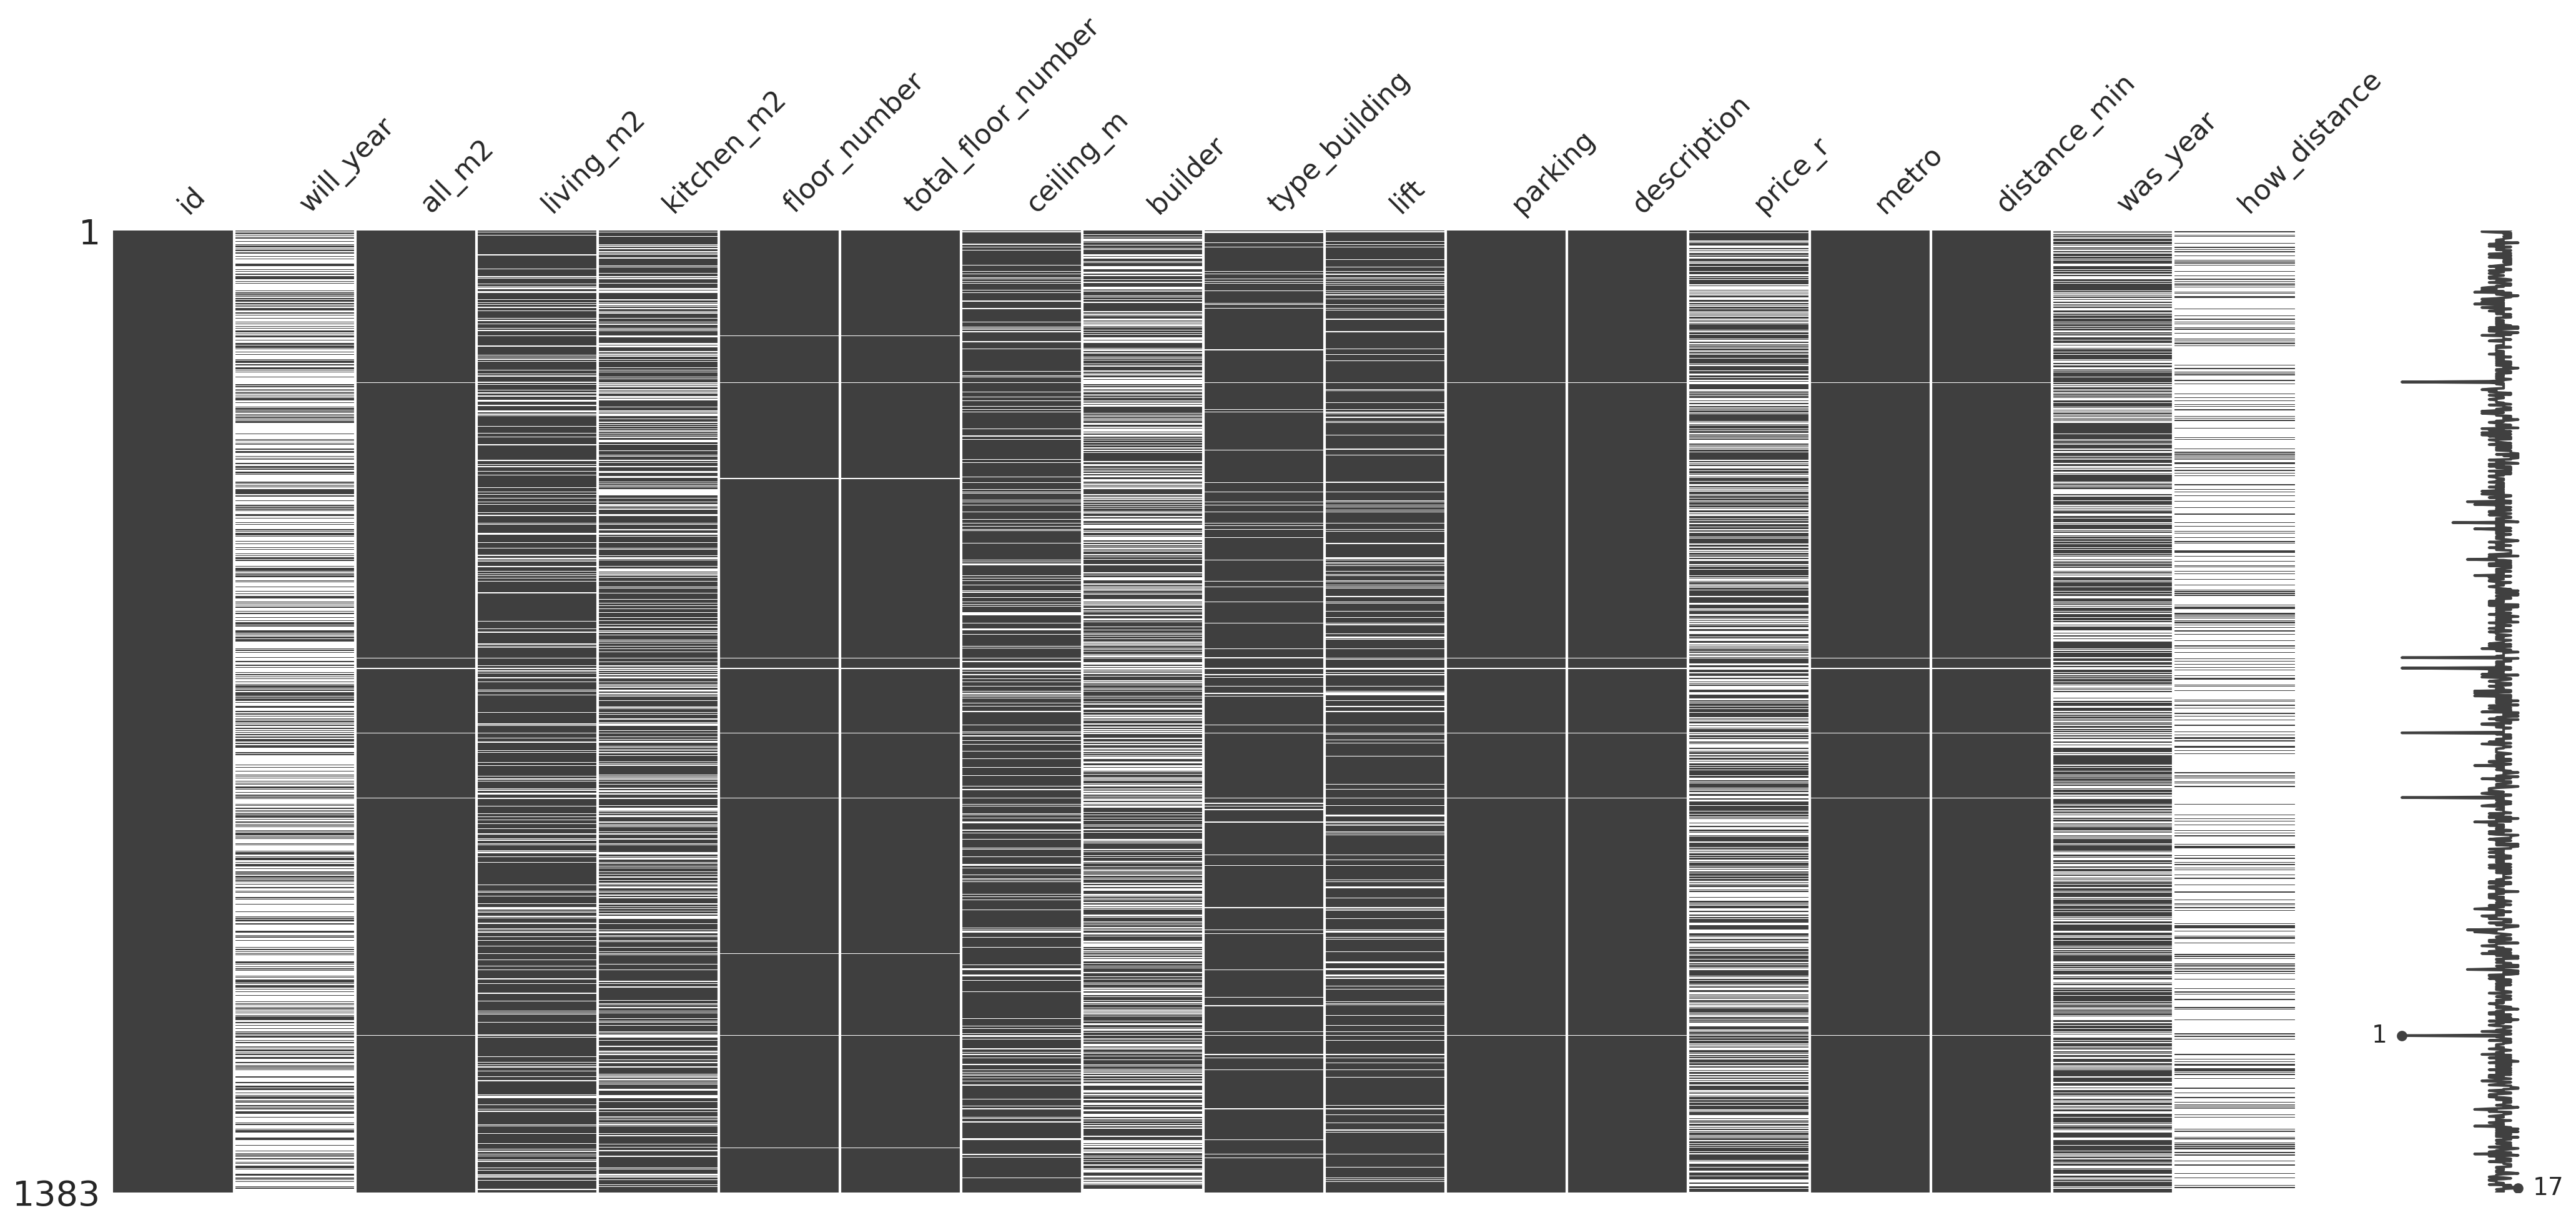

In [ ]:
import missingno as msn
msn.matrix(df)

Columns:
- 'will_year' - when it will be constructed
- 'was_year' - when it was constructed

are almost the same, let's join them and create one more feature - year

In [ ]:
df['year'] = df['was_year'].fillna(df['will_year'])
df = df.drop(['will_year', 'was_year'], axis=1)

#### We now have only 27 NAs for *year* feature values which is much better

In [ ]:
df.year.isna().sum()

27

#### Next is *ceiling_m* column, but before that, let's create a new categorical variable before we fill in the data. We create a new categorical variable based on the new column *year* we created. We group our houses based on the year they were built, or are planned to be built

In [ ]:
df['year'] = df['year'].fillna(0).astype(int)

conditions = [ (df['year'] == 0),
              ((df['year'] > 0) & (df['year']<= 1991)),
              ((df['year'] > 1991) & (df['year']<= 2015)),
              ((df['year'] > 2015) & (df['year']<= 2024)),
              (df['year'] > 2024)]
choices = ['UNKNOWN', 'USSR', 'Recent', 'More_Recent', 'New_Building']
df["year_group"] = np.select(conditions, choices, default=np.nan)

#### Our idea is that older buildings and more recent building usually have different ceiling heights, because building standard probably changed, so let's look at the mode ceiling height by periods

In [ ]:
df.groupby('year_group')['ceiling_m'].agg(pd.Series.mode)

,ceiling_m
year_group,
More_Recent,3.00
New_Building,2.85
Recent,3.00
UNKNOWN,3.00
USSR,2.64


#### It looks for periods before 1991, 2.65 was the standard height, so we fill empty ceiling heights with 2.65 when its USSR, and with 3 meters if its not

In [ ]:
dmap = {'USSR': 2.65, 'More_Recent': 3.00, 'New_Building': 2.85, 'Recent': 3, 'UNKNOWN': 3}

df['ceiling_m'] = df['ceiling_m'].fillna(df['year_group'].map(dmap))


In [ ]:
df['ceiling_m'].describe()

,ceiling_m
count,1383.000000
mean,2.974165
std,0.773615
min,2.000000
25%,2.700000
50%,2.900000
75%,3.000000
max,21.700000


Let's fill as 'UNKNOWN' columns 'builder', 'type_building' to filter them later.

Let's introduce new column - 'by_transport' when people should use autobuses to get the subway stations

In [ ]:
df['builder'] = df['builder'].fillna(value='UNKNOWN')
df['type_building'] = df['type_building'].fillna(value='UNKNOWN')
df['by_transport']=df['how_distance'].fillna(value='No').map(lambda x: 1 if x!='No' else 0)

'how_distance' is not necessary now

In [ ]:
df = df.drop(['how_distance'], axis=1)

We now also do the same for lift variable and turn it to binary one

In [ ]:
df['lift']=df['lift'].fillna(value='No').map(lambda x: 1 if x!='No' else 0)

Now many builders offer flexible space without walls, for such flats, if the kitchen area is missing, let's define it by subtracting living space from total space and then vice versa

In [ ]:
df['kitchen_m2'] = df['kitchen_m2'].fillna(df['all_m2']-df['living_m2'])
df['living_m2'] = df['living_m2'].fillna(df['all_m2']-df['kitchen_m2'])

#### There are still empty cases of *kitchen_m2* and *living_m2*, so let's do a similar thing that we did with ceilings, but now we will use a share of living space from the total space, based on *all_m2* category. Before that, we can drop all rows where *all_m2* is empty because there are not many such values (only 6) and this variable has to be very important for price prediction

In [ ]:
df.all_m2.isna().sum()

6

In [ ]:
df = df.drop(df[df['all_m2'].isnull()].index)

#### We create categories based on flat total area, and then store the median values in a separate dataframe, then we join two dataframes and fill in the empty values with appropriate ratios from the total space of the flat

In [ ]:
conditions = [ (df['all_m2'] <= 45),
              ((df['all_m2'] > 45) & (df['all_m2']<= 70)),
              ((df['all_m2'] > 70) & (df['all_m2']<= 100)),
              (df['all_m2'] > 100)]
choices = ['Small', 'Middle', 'Large', 'Very_Large']
df["all_m2_group"] = np.select(conditions, choices, default=np.nan)

In [ ]:
df['kitchen_share'] = df['kitchen_m2'] / df['all_m2']
median_shares = df.groupby('all_m2_group')['kitchen_share'].median().reset_index()
median_shares = median_shares.rename(columns = {'kitchen_share':'median_kitchen_share'})

In [ ]:
df = df.merge(median_shares, how = 'left', on = 'all_m2_group')

In [ ]:
df['kitchen_m2'] = np.where(df['kitchen_m2'].isna(), df['all_m2'] * df['median_kitchen_share'], df['kitchen_m2'])
df['living_m2'] = np.where(df['living_m2'].isna(), df['all_m2'] - df['kitchen_m2'], df['living_m2'])

#### We have left *floor number*, *total_floor_number* and *price_r* left which also have NAs. For first two, we can drop those, because there are not many of those, and it is hard to fill them in by some logic

In [ ]:
df.floor_number.isna().sum(), df.total_floor_number.isna().sum(),

(4, 4)

In [ ]:
df = df.drop(df[df['floor_number'].isnull()].index)

#### For *price_r* there are many NAs, dropping them might be too expensive, lets fill in empty values by creating new variable that counts rooms based on data description




In [ ]:
df.price_r.value_counts(dropna = False, normalize = True)

,proportion
price_r,
<NA>,0.405681
14500000,0.005827
11500000,0.005098
40000000,0.00437
9500000,0.00437
...,...
20027780,0.000728
19250000,0.000728
19409684,0.000728


In [ ]:
def room_count(text):
    splitted = str(text).split(sep=',')
    if len(splitted)<=1:
        return None
    else:
        return text_to_number(splitted[-1])

In [ ]:
df['room_count'] = df['description'].map(room_count)
df['room_count'] = df['room_count'].convert_dtypes()
df = df.drop(df[df['room_count'].isnull()].index)
df = df.reset_index(drop=True)

#### Looking at median prices based on room count, very large flats do not seem to have prices in them, probably because such flats prices are negotiated in person

In [ ]:
df.groupby('room_count')['price_r'].median()

,price_r
room_count,
1,12316905.5
2,19500000.0
3,32115500.0
4,62500000.0
5,106092648.0
6,84500000.0
7,230000000.0
8,<NA>
9,<NA>


#### Let's fill in the empty price_r values with median prices based on the number of rooms in a flat

In [ ]:
df['price_r'] = df['price_r'].astype(float)
df['price_r'] = df['price_r'].fillna(df.groupby('room_count')['price_r'].transform('median'))
df = df.drop(df[df['price_r'].isnull()].index)
df['price_r'] = df['price_r'].astype(int)

#### Now, let's get rid of outliers in the price_r column

In [ ]:
quantiles = [0.25, 0.5, 0.75, 0.90, 0.95, 0.975, 0.99, 0.997, 0.999, 1]
quantile_df = df['price_r'].quantile(quantiles).reset_index()
quantile_df.columns = ['Quantile', 'Value']
quantile_df['Value'] = quantile_df['Value'].apply(lambda x: f'{x:,.0f}')
quantile_df

,Quantile,Value
0,0.250,"13,967,745"
1,0.500,"19,500,000"
2,0.750,"32,865,849"
3,0.900,"84,006,659"
4,0.950,"108,033,365"
5,0.975,"204,965,000"
6,0.990,"295,325,407"
7,0.997,"572,936,400"
8,0.999,"954,355,646"
9,1.000,"1,730,000,000"


In [ ]:
df = df[df['price_r'] < 572936400]

In [ ]:
df = df.drop(columns = ['kitchen_share', 'median_kitchen_share']) # Let's drop those columns that we used for filling in the empty columns

#### This is how the quality of our prepared dataset looks like:

<Axes: >

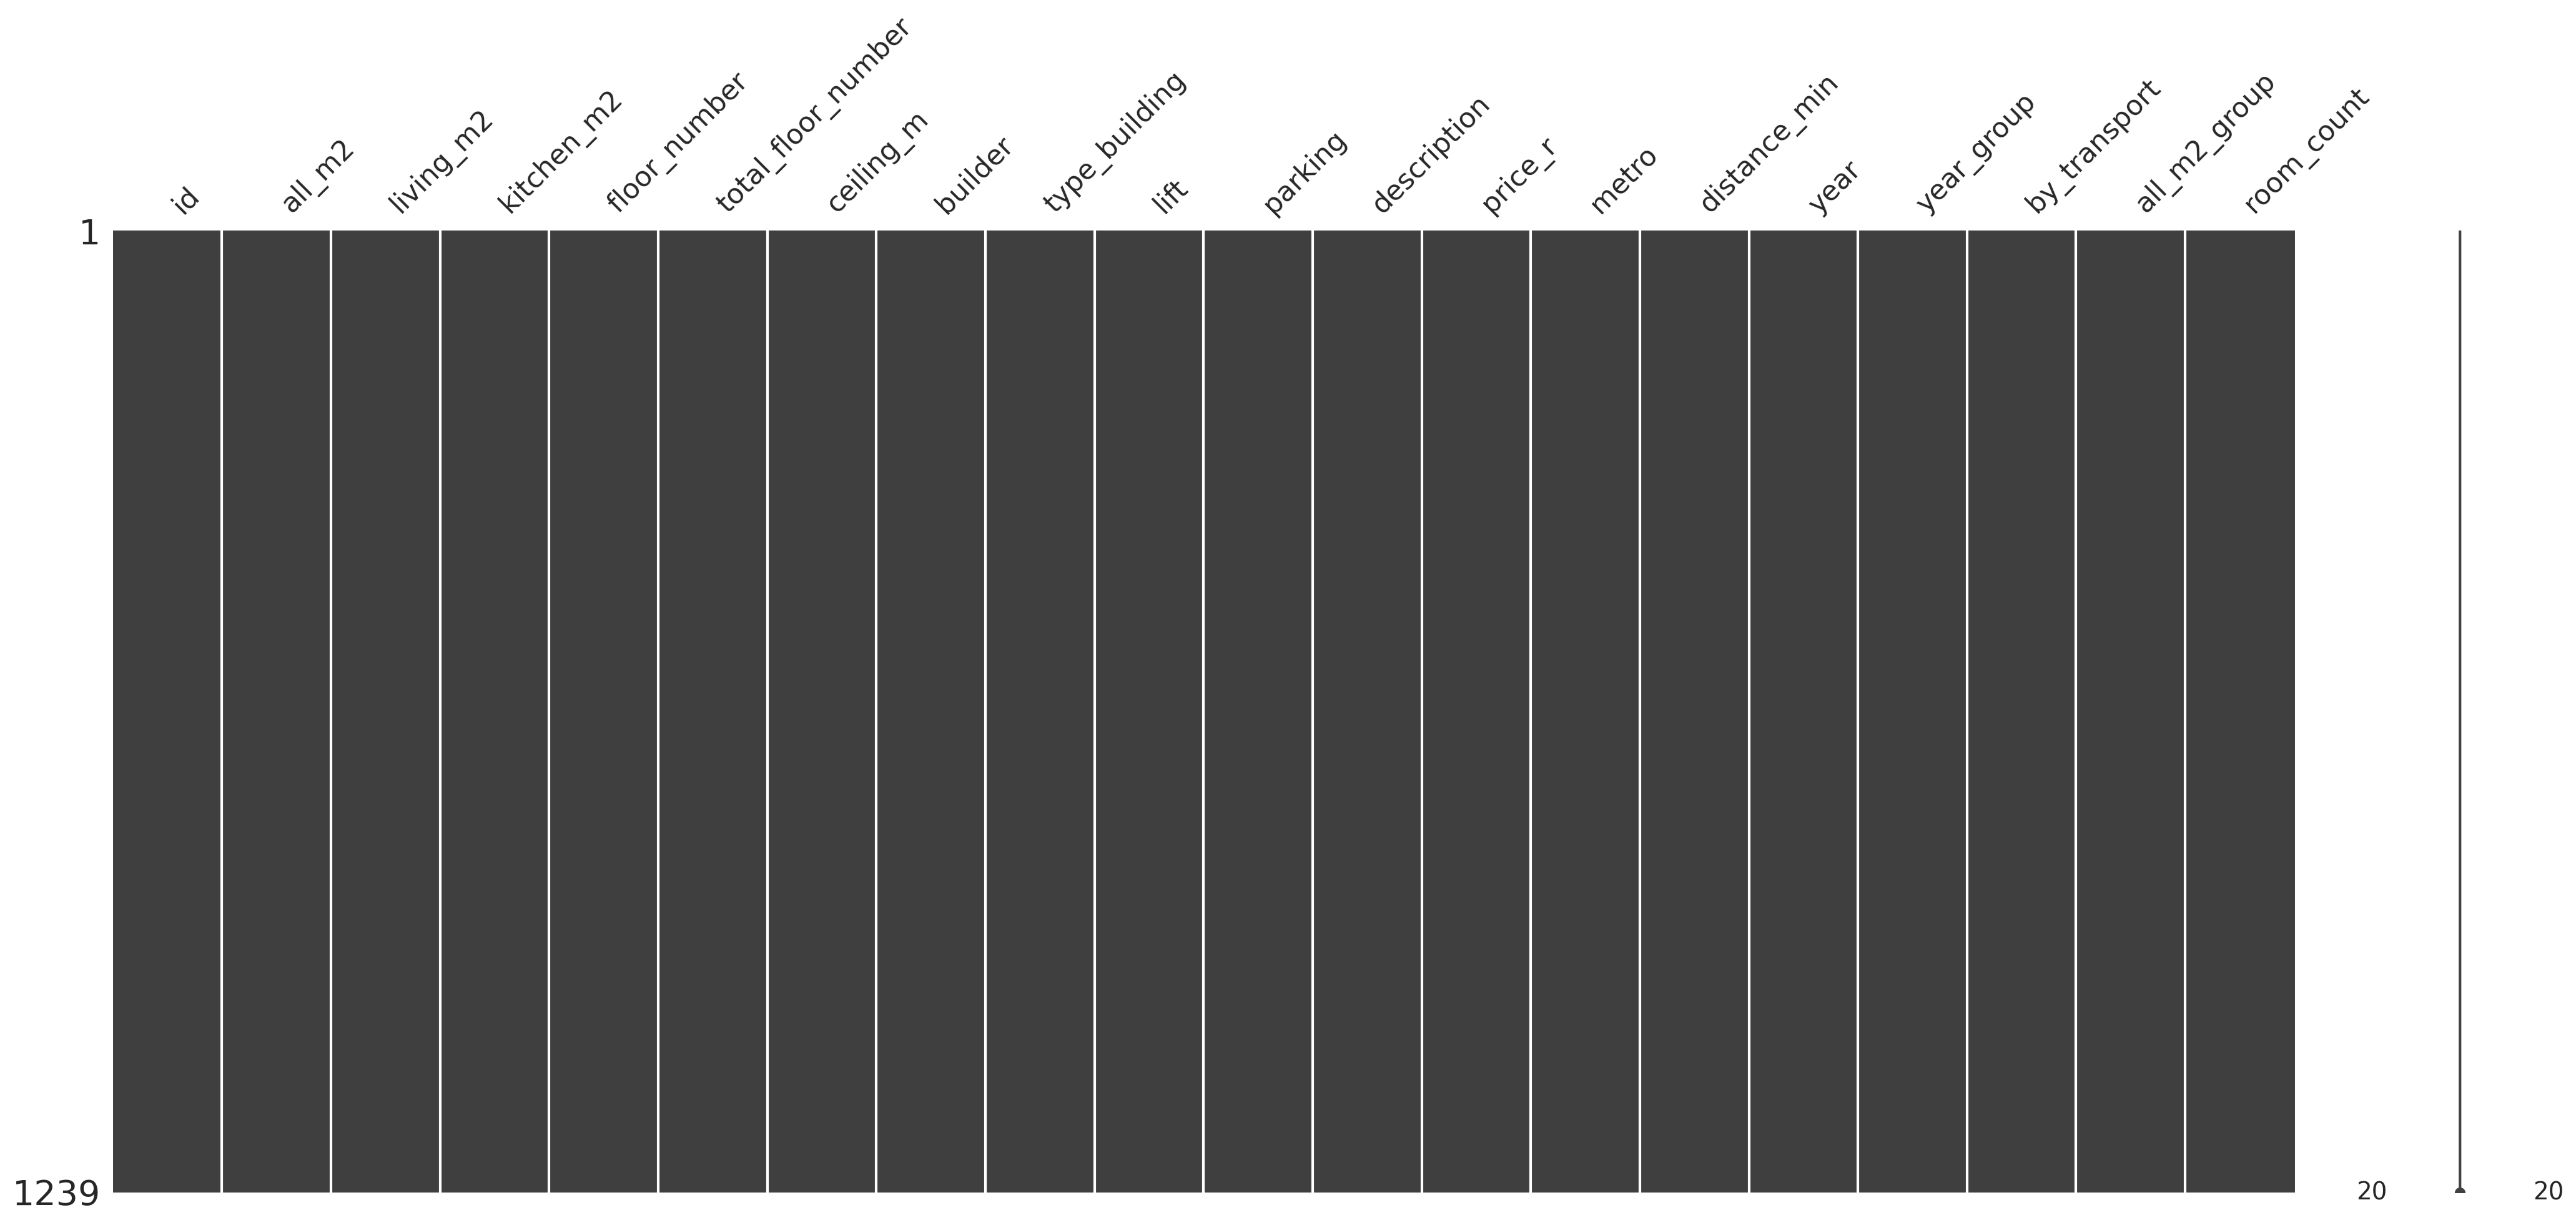

In [ ]:
msn.matrix(df)

#### 4) Creating new features

The next step is to map approximately subway station with  districts. For 'new Moscow' 'Отдельный' district is used. The distribution is approximate but it can be useful for analysis

In [ ]:
metro_ao ={}
for i in ['ЗАО', 'ЦАО', 'ВАО', 'САО', 'ЮАО', 'Отдельный', 'СВАО', 'СЗАО', 'ЮВАО', 'ЮЗАО']:
    with open(i + '.txt', 'r' , encoding='utf-8') as file:
        metro_ao[i] = file.read()
def metro_to_ao(text):
    metro = str(text).lower()
    for (k, v) in metro_ao.items():
        if metro.replace('ё', 'e') in v.lower().replace('ё', 'e'):
            return k
    return 'Отдельный'

In [ ]:
df['district'] = df['metro'].map(metro_to_ao)
df.groupby('district')['id'].count()

,id
district,
ВАО,58
ЗАО,160
Отдельный,257
САО,104
СВАО,63
СЗАО,75
ЦАО,219
ЮАО,104
ЮВАО,84


Intermidiate check: average price by districts

In [ ]:
df.groupby('district')['price_r'].mean()

,price_r
district,
ВАО,2.029756e+07
ЗАО,4.950974e+07
Отдельный,2.671110e+07
САО,2.661185e+07
СВАО,2.609349e+07
СЗАО,2.715983e+07
ЦАО,7.907675e+07
ЮАО,2.295470e+07
ЮВАО,2.063442e+07


Also let's introduce useful feature: average price of 1 m2

In [ ]:
df['average_price'] =  (df['price_r'] / df['all_m2']).round(0)
df['average_price'] = df['average_price'].convert_dtypes()

df.groupby('district')['average_price'].mean()

,average_price
district,
ВАО,348324.051724
ЗАО,492397.34375
Отдельный,367564.708171
САО,368856.192308
СВАО,378484.571429
СЗАО,405998.986667
ЦАО,628976.105023
ЮАО,381335.855769
ЮВАО,359739.071429


#### Let'so add a feature that will highlight whether a flat is on the 1st floor or highest floor. To our knowledge, those flats usually have lower prices:

In [ ]:
df['low_high'] = np.where((df['floor_number'] == df['total_floor_number']) | (df['floor_number'] == 1),
                           1,
                           0)

In [ ]:
df['low_high'].value_counts(normalize = True)

,proportion
low_high,
0,0.909605
1,0.090395


### Now, let's quantify our categorical variables for them to be used in our future ML model. Metro variable is not needed because we already have a district variable, and for builder column, there are too many unique values

In [ ]:
df_obj_features = df.select_dtypes(include='object')
df_obj_features = df_obj_features.drop(columns = ['id', 'description' , 'metro', 'builder'])
df_obj_features.describe()

,type_building,parking,year_group,all_m2_group,district
count,1239,1239,1239,1239,1239
unique,7,4,5,4,10
top,Монолитное здание,Открытая парковка,New_Building,Middle,Отдельный
freq,600,1030,398,413,257


In [ ]:
dummies = pd.get_dummies(df_obj_features, prefix=df_obj_features.columns, drop_first=False)

In [ ]:
dummies

,type_building_UNKNOWN,type_building_Блочное здание,type_building_Деревянное здание,type_building_Кирпично-монолитное здание,type_building_Кирпичное здание,type_building_Монолитное здание,type_building_Панельное здание,parking_Закрытая парковка,parking_Многоуровневая парковка,parking_Открытая парковка,...,district_ВАО,district_ЗАО,district_Отдельный,district_САО,district_СВАО,district_СЗАО,district_ЦАО,district_ЮАО,district_ЮВАО,district_ЮЗАО
0,False,False,False,False,False,True,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
3,True,False,False,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
1242,False,False,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,True,False,False
1243,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
1244,False,False,False,False,False,True,False,False,False,True,...,False,True,False,False,False,False,False,False,False,False


In [ ]:
df = pd.concat([df, dummies], axis=1)

save data

In [ ]:
df.to_csv('data.csv', sep='\t', encoding='utf-8')

#### 5) Visual analysis with graphs

In [ ]:
import pandas as pd
df = pd.read_csv('data.csv', sep='\t', encoding='utf-8', index_col=0)

### Description
The data contains 1239 non-null rows for 52 columns.
#### Column description
- id - reference to original card
- all_m2 - total m^2 of flat (cannot be 0)
- living_m2 - m^2 of living space (can be 0 if it is not given)
- kitchen_m2 - m^2 of kitchen  (can be 0 if it is not given)
- floor_number - the number of flat's floor
- total_floor_number - the total floor number of the current building
- ceiling_m - height of the flat
- builder - which company built this house
- type_building - type of building (can be 'UNKNOWN', 'Блочное здание', 'Деревянное здание', 'Кирпично-монолитное здание', 'Кирпичное здание', 'Монолитное здание', 'Панельное здание')
- lift - if this building has a lift
- parking - type of parking (can be 'Закрытая парковка', 'Многоуровневая парковка', 'Открытая парковка', 'Подземная парковка')
- description - the general description of the flat
- price_r - price in rubles
- metro - the nearest subway station
- distance_min - distance to the nearest subway station in minutes
- year - year of construction
- year - categorical grouping for year
- by_transport - if by_transport is given for public transport
- all_m2_group - categorical grouping of flats based on total area
- room_count - the number of rooms (new feature)
- district - approximate district of Moscow (new feature)
- average_price - price of 1 m^2 in rubles (new feature)
- low_high - whether the flat is on the first of top floor of the building
- other dummies for categorical variables

In [ ]:
df.head(5)

,id,all_m2,living_m2,kitchen_m2,floor_number,total_floor_number,ceiling_m,builder,type_building,lift,...,district_ВАО,district_ЗАО,district_Отдельный,district_САО,district_СВАО,district_СЗАО,district_ЦАО,district_ЮАО,district_ЮВАО,district_ЮЗАО
0,/offer/6328777127894859155/,54.9,33.400000,6.700000,16,18,3.14,Застройщик ГК «А101»,Монолитное здание,1,...,False,False,True,False,False,False,False,False,False,False
1,/offer/6249958057991401381/,40.5,19.300000,10.500000,14,22,3.00,Застройщик ГК ФСК,UNKNOWN,0,...,False,False,True,False,False,False,False,False,False,False
2,/offer/4436300590218059257/,65.5,52.775938,12.724062,7,22,2.85,"Застройщики ГК «Развитие», ГлавГрадоСтрой",UNKNOWN,0,...,False,False,False,False,False,False,False,False,False,True
3,/offer/7732108553124534775/,57.0,20.100000,22.100000,5,8,4.00,Застройщик ПАТЕК ГРУПП,UNKNOWN,1,...,False,False,False,False,True,False,False,False,False,False
4,/offer/2316491653782316494/,94.0,35.900000,16.200000,6,13,3.60,Застройщик MR Group,Кирпично-монолитное здание,1,...,False,False,False,False,False,False,True,False,False,False


In [ ]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 12
mpl.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

### Let's see how number of floors and years of building correlate with each other.

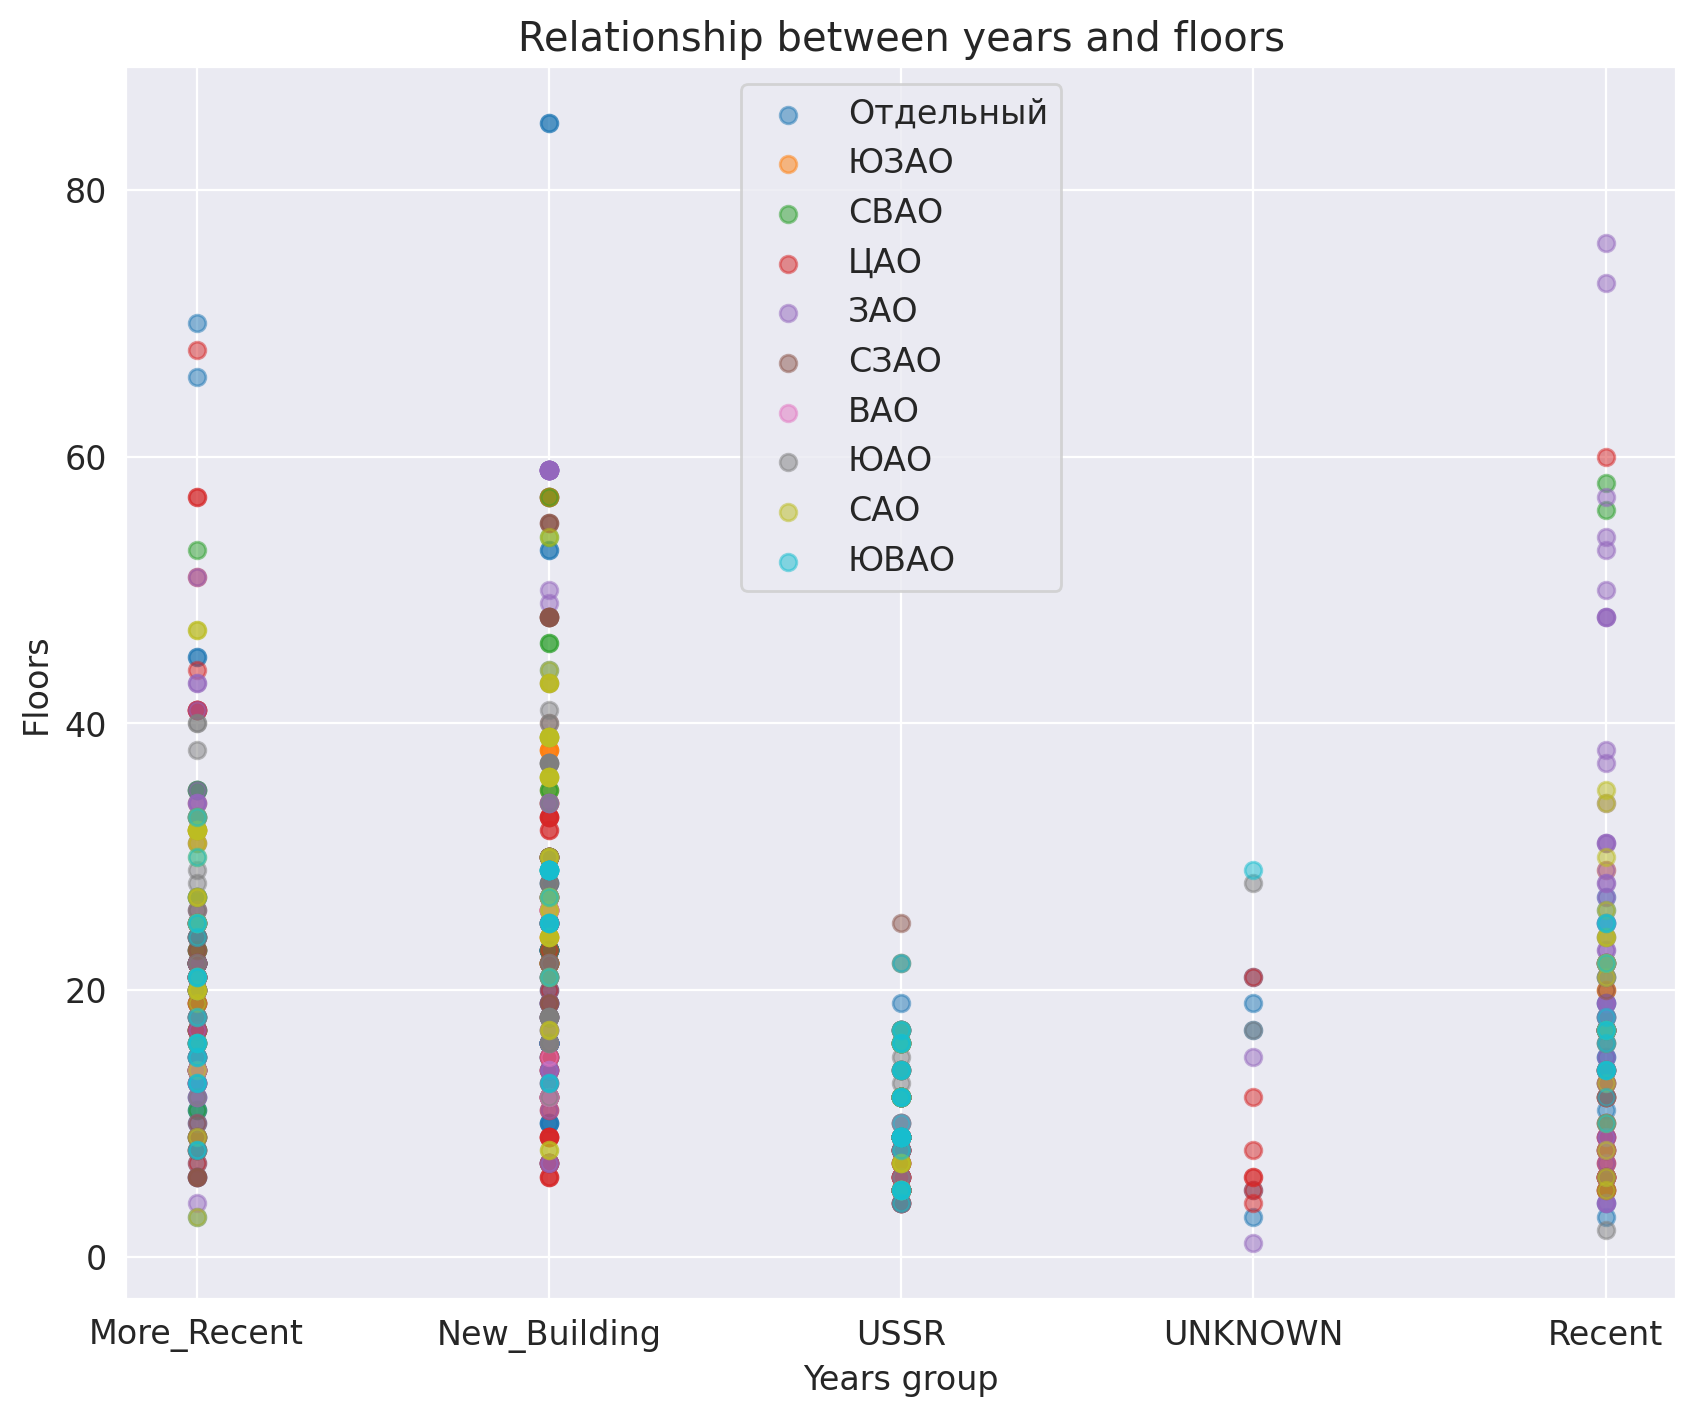

In [ ]:
unique_values_districts = df['district'].unique()
all = []
for d in unique_values_districts:
  by_district = df[df['district']==d]
  c = plt.scatter(x=by_district['year_group'],y=by_district['total_floor_number'], alpha=.5)
  all.append(c)
plt.legend(all,
           unique_values_districts,
           scatterpoints=1)

plt.xlabel("Years group")
plt.ylabel("Floors")
plt.title('Relationship between years and floors')

plt.show()

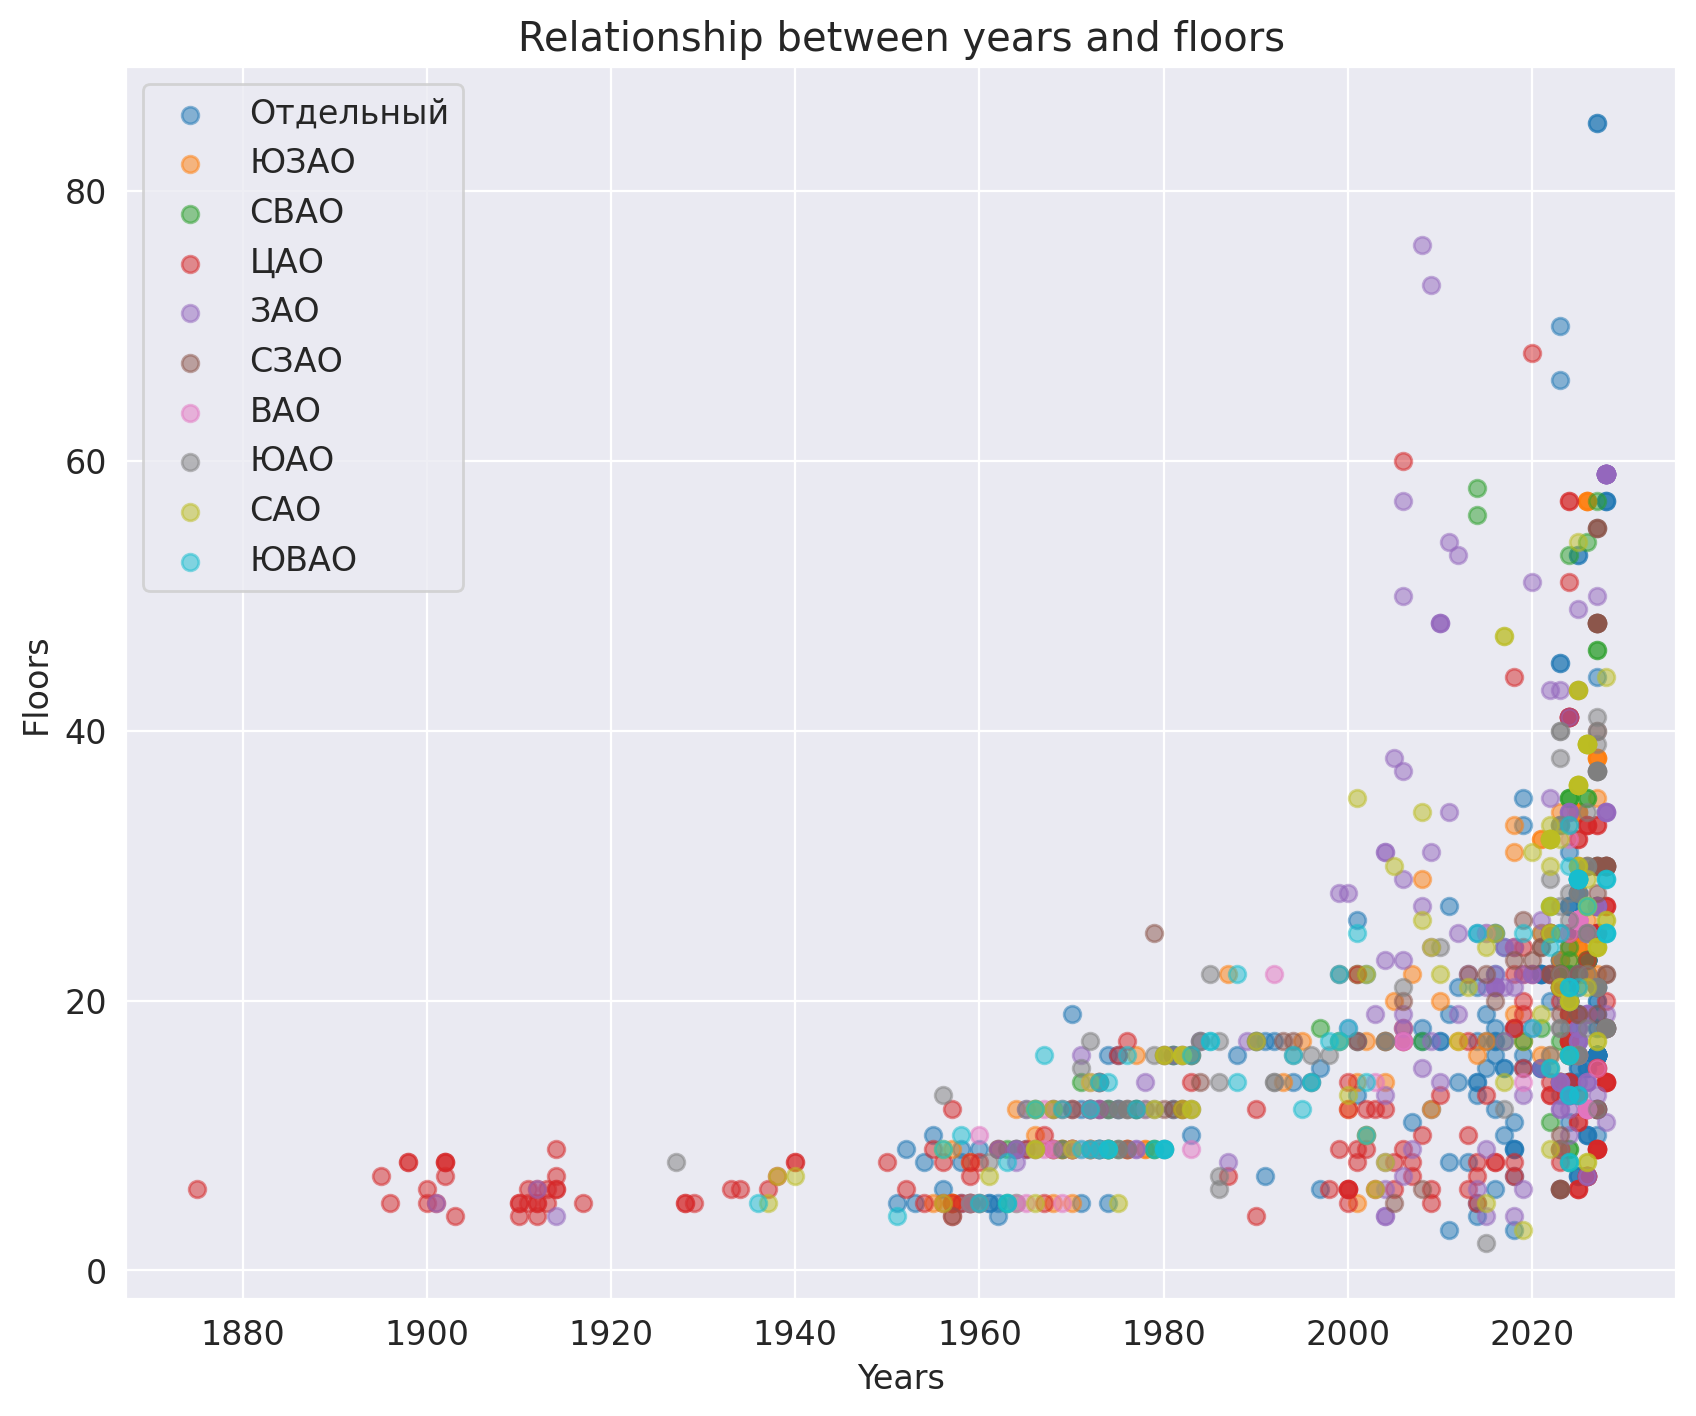

In [ ]:
current_df = df[df['year']!=0]
unique_values_districts = current_df['district'].unique()
all = []
for d in unique_values_districts:
  by_district = current_df[current_df['district']==d]
  c = plt.scatter(x=by_district['year'],y=by_district['total_floor_number'], alpha=.5)
  all.append(c)
plt.legend(all,
           unique_values_districts,
           scatterpoints=1)

plt.xlabel("Years")
plt.ylabel("Floors")
plt.title('Relationship between years and floors')

plt.show()

You can see that many-floor buildings got popular after 1990s and the leader is 'Отдельный' district

### Heatmap for correlation between years and room count

It seems that it should be correlated with years and can be small finally

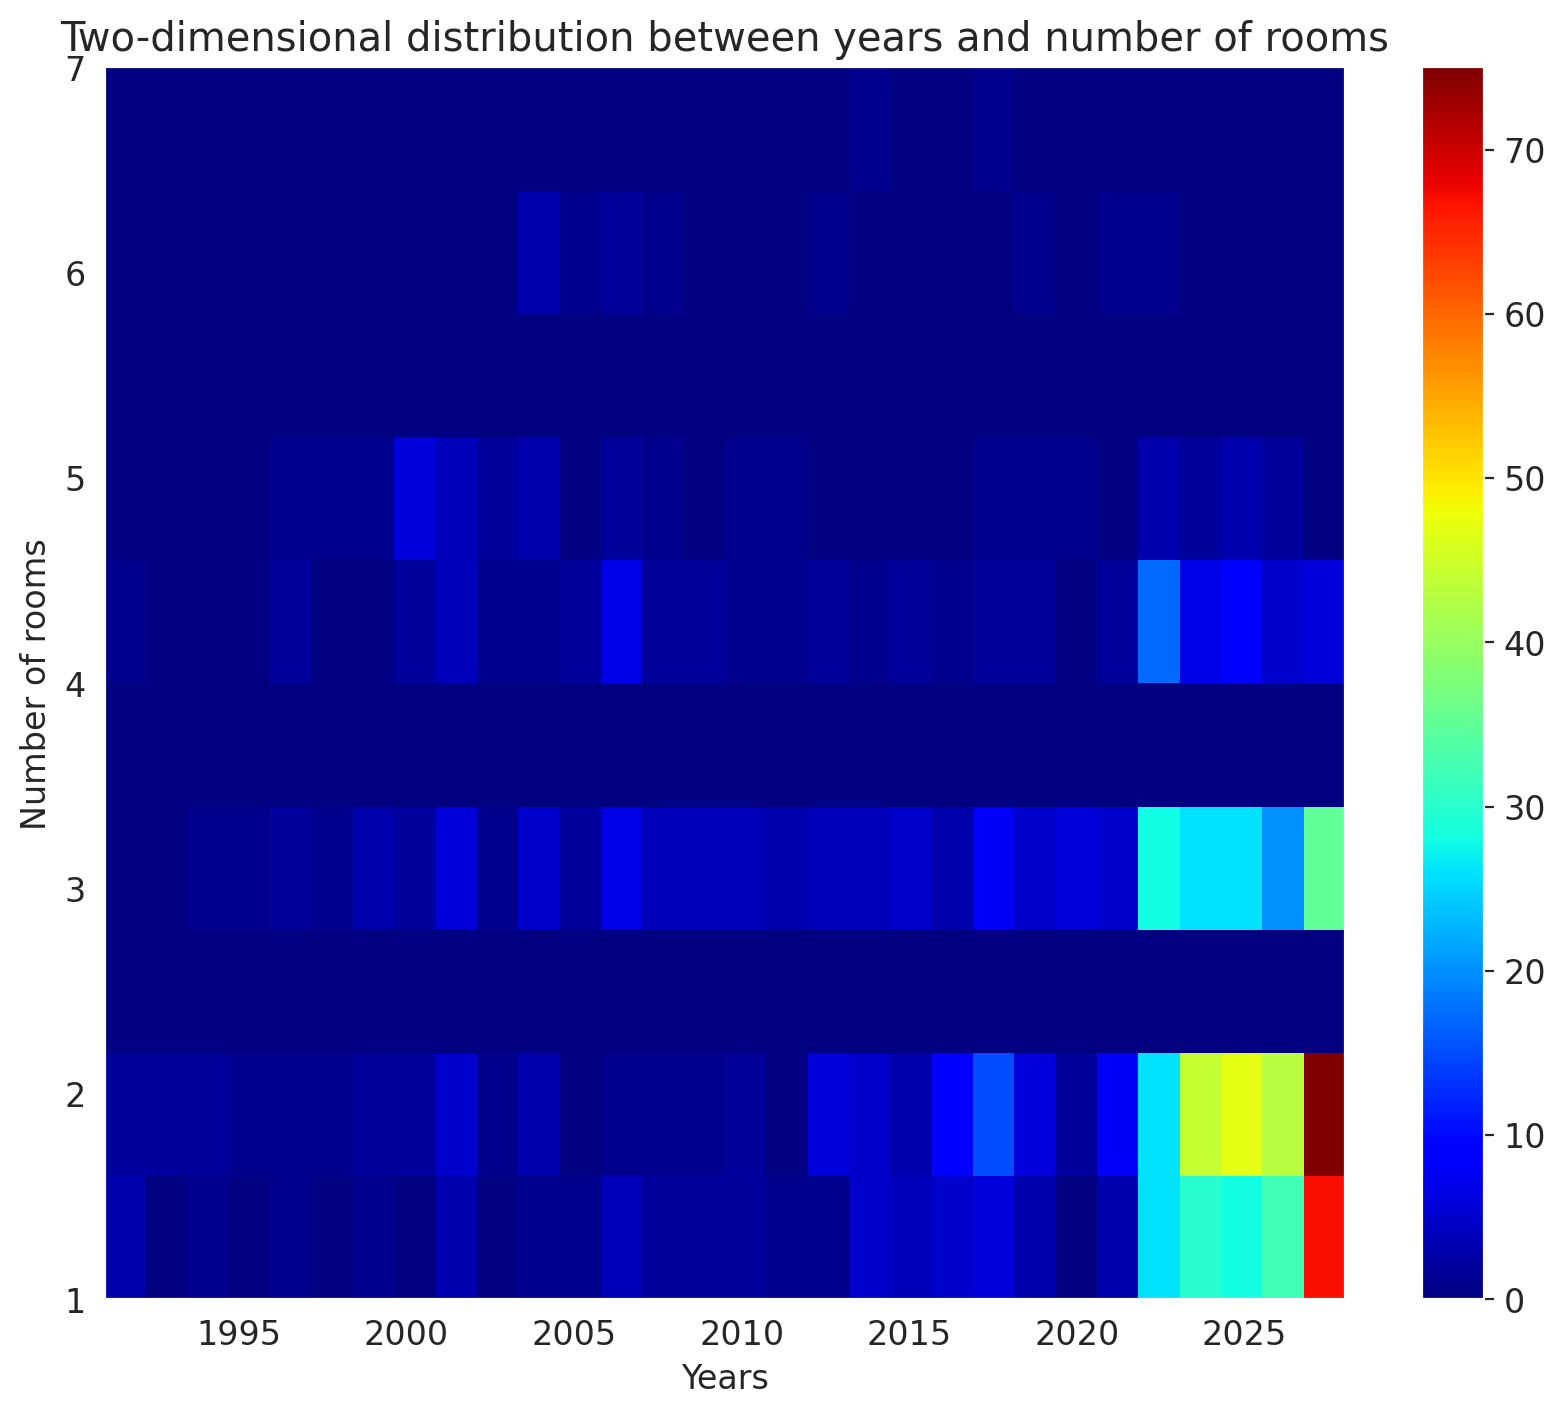

In [ ]:
current_df = df[df['year']>1990]

plt.hist2d(x = current_df['year'], y=current_df['room_count'], bins=(30, 10), cmap=plt.cm.jet)
plt.colorbar()

# Add labels and title
plt.xlabel('Years')
plt.ylabel('Number of rooms')
plt.title('Two-dimensional distribution between years and number of rooms')

# Display the plot
plt.show()


So, recently the most popular flats with 1 and 2 rooms

### Average price of 1 m2 by districts
it is expected that the highest must be in the central district

In [ ]:
current_df = df[df['average_price']!=0][['average_price', 'district']].groupby('district').mean()
current_df['average_price'] = (current_df['average_price']/1000)
current_df

,average_price
district,
ВАО,348.324052
ЗАО,492.397344
Отдельный,367.564708
САО,368.856192
СВАО,378.484571
СЗАО,405.998987
ЦАО,628.976105
ЮАО,381.335856
ЮВАО,359.739071


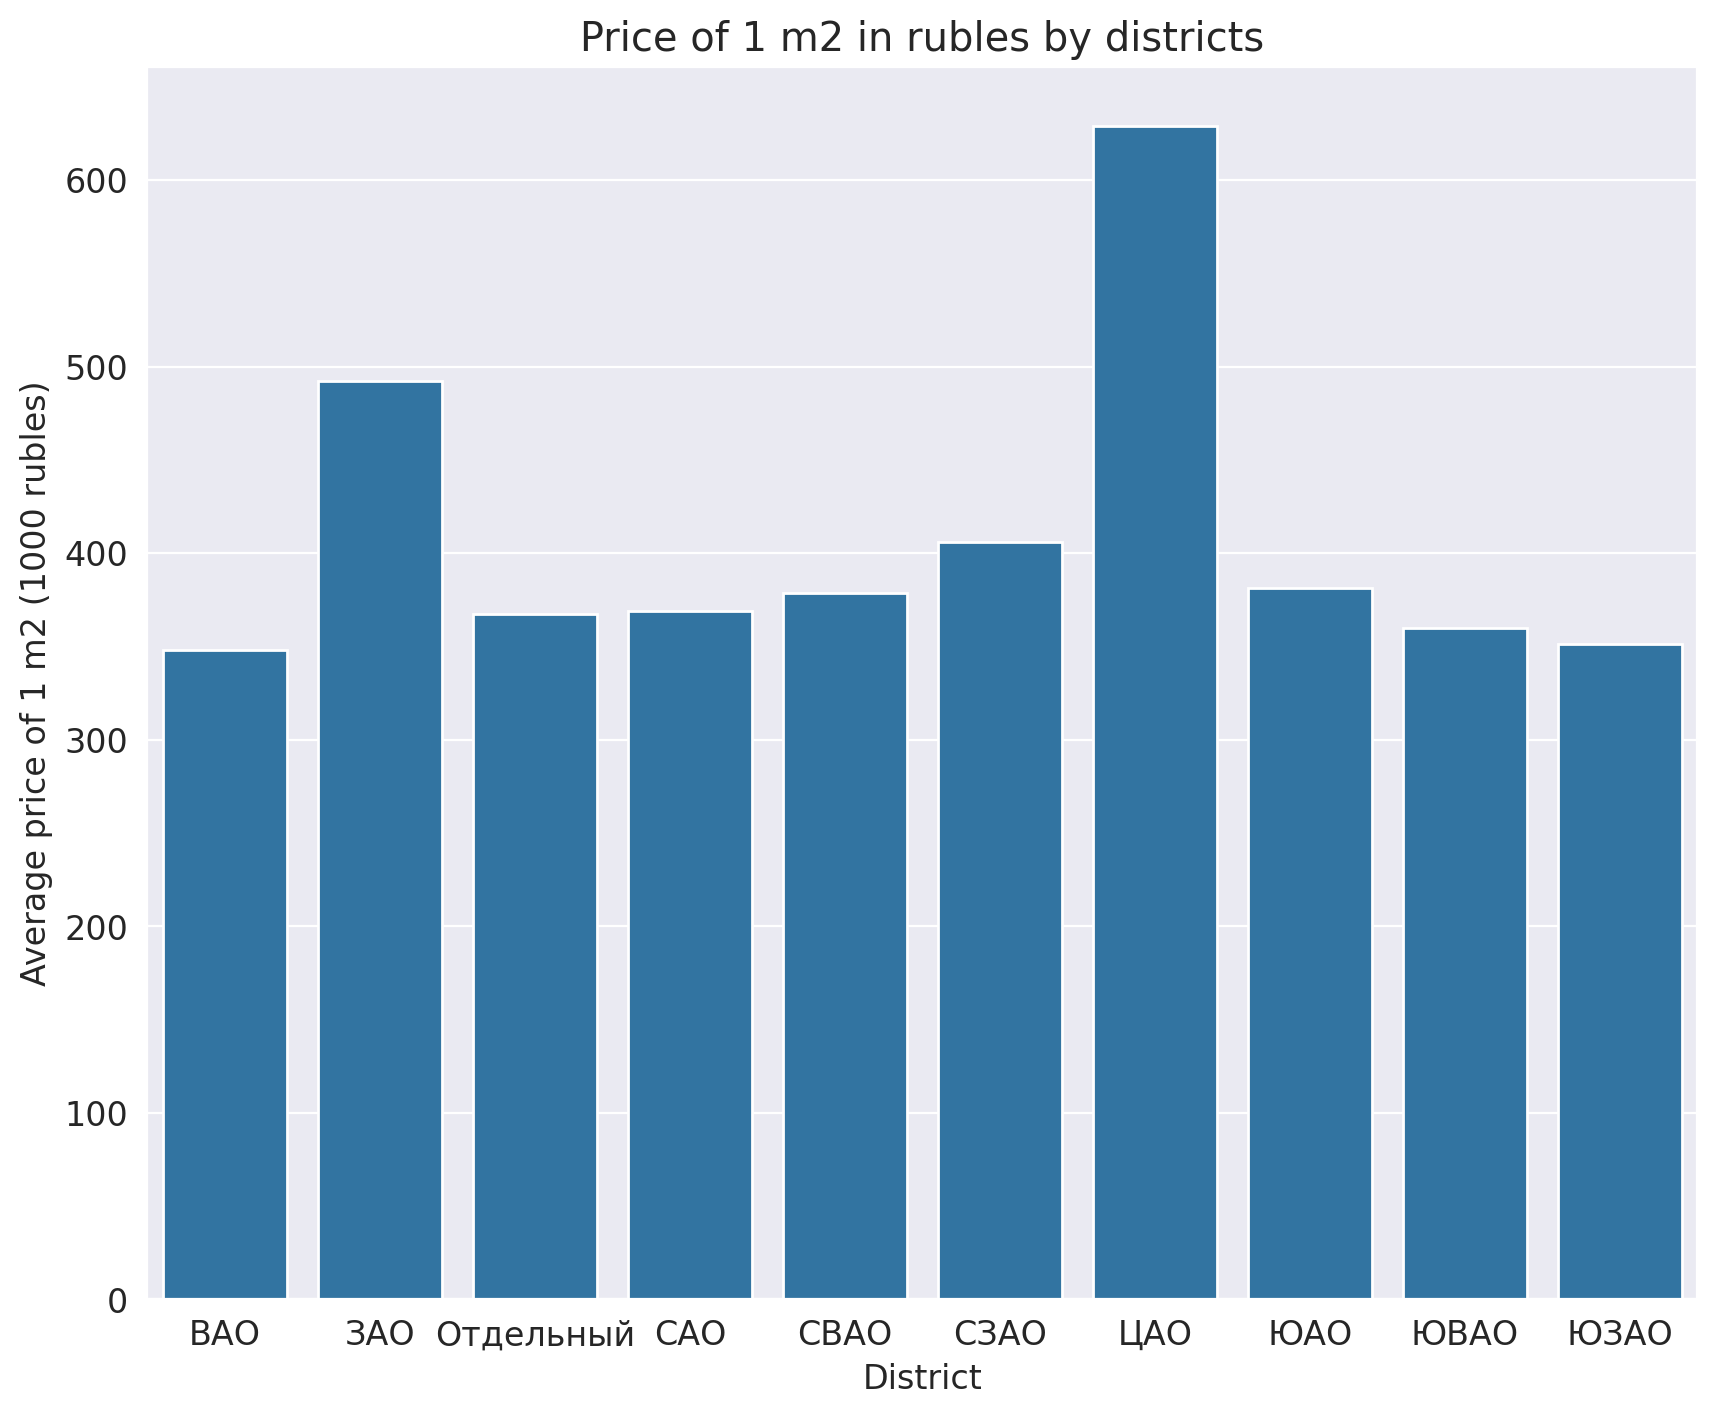

In [ ]:
ax = sns.barplot(current_df, x="district", y="average_price")
ax.set_title('Price of 1 m2 in rubles by districts')
plt.ylabel("Average price of 1 m2 (1000 rubles)")
plt.xlabel("District")
plt.show()

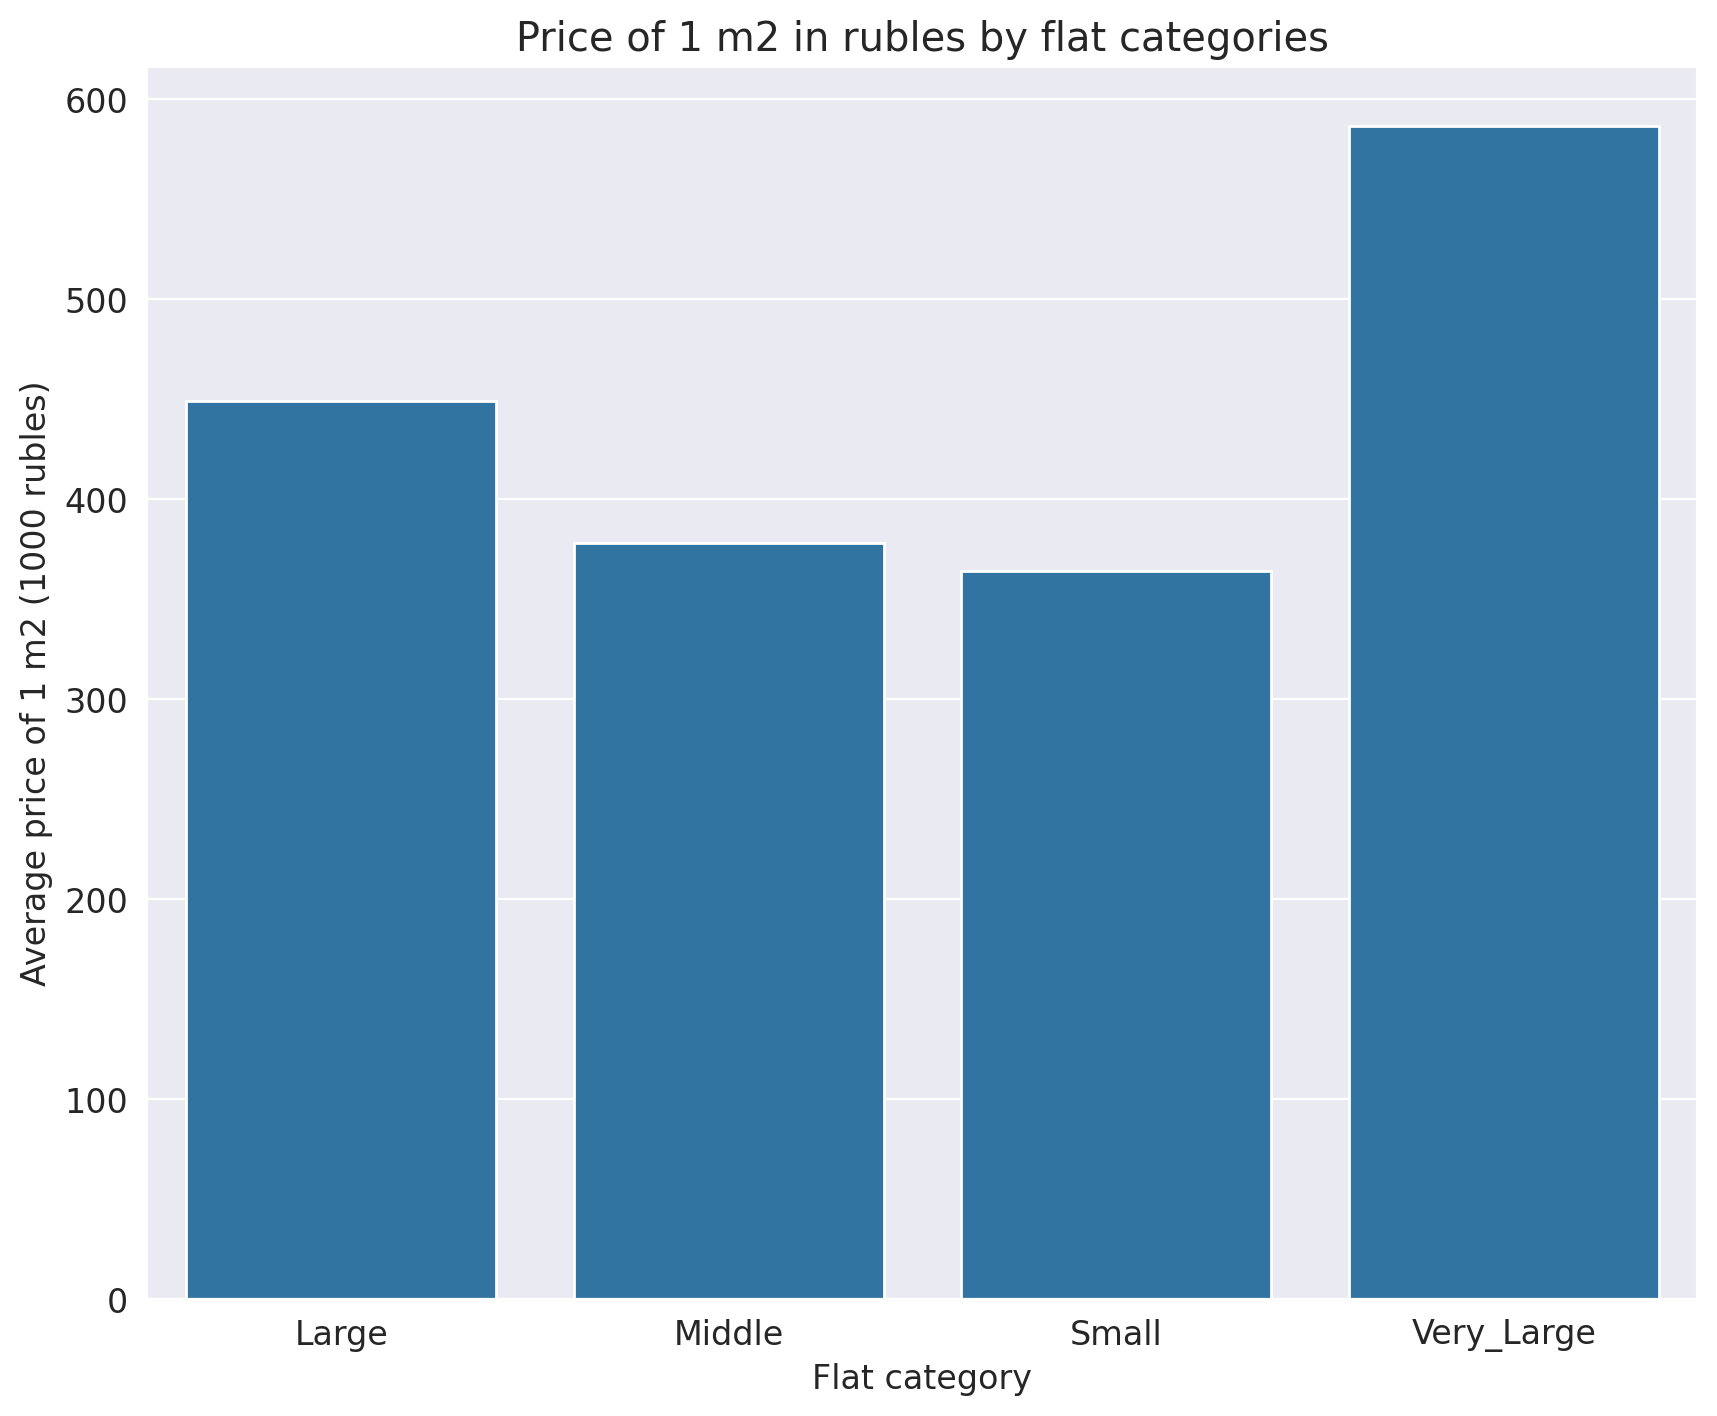

In [ ]:
current_df = df[['average_price', 'all_m2_group']].groupby('all_m2_group').mean()
current_df['average_price'] = (current_df['average_price']/1000)
current_df

ax = sns.barplot(current_df, x="all_m2_group", y="average_price")
ax.set_title('Price of 1 m2 in rubles by flat categories')
plt.ylabel("Average price of 1 m2 (1000 rubles)")
plt.xlabel("Flat category")
plt.show()

#### Let's see which numerical variables correlate the best with the target variable which is price_r

In [ ]:
df_num_features = df.select_dtypes(include=['float64', 'Int64'])

In [ ]:
df_num_features = df_num_features.drop(columns = ['average_price']) # We drop average price, because its basically the same variable

#### We can see that short distance to metro, low total number of floors (less neighbours) have a positive correlation with price. The floor number of the flat, the year built, the ceiling height and whether a feature has a highest or lowest floor seem to not have much effect on price. Also, the bigger the flat, the bigger is the price as expected. Surprisingly the presence of lift shows a negative correlation, perhaps this variable is better to be dropped from the model

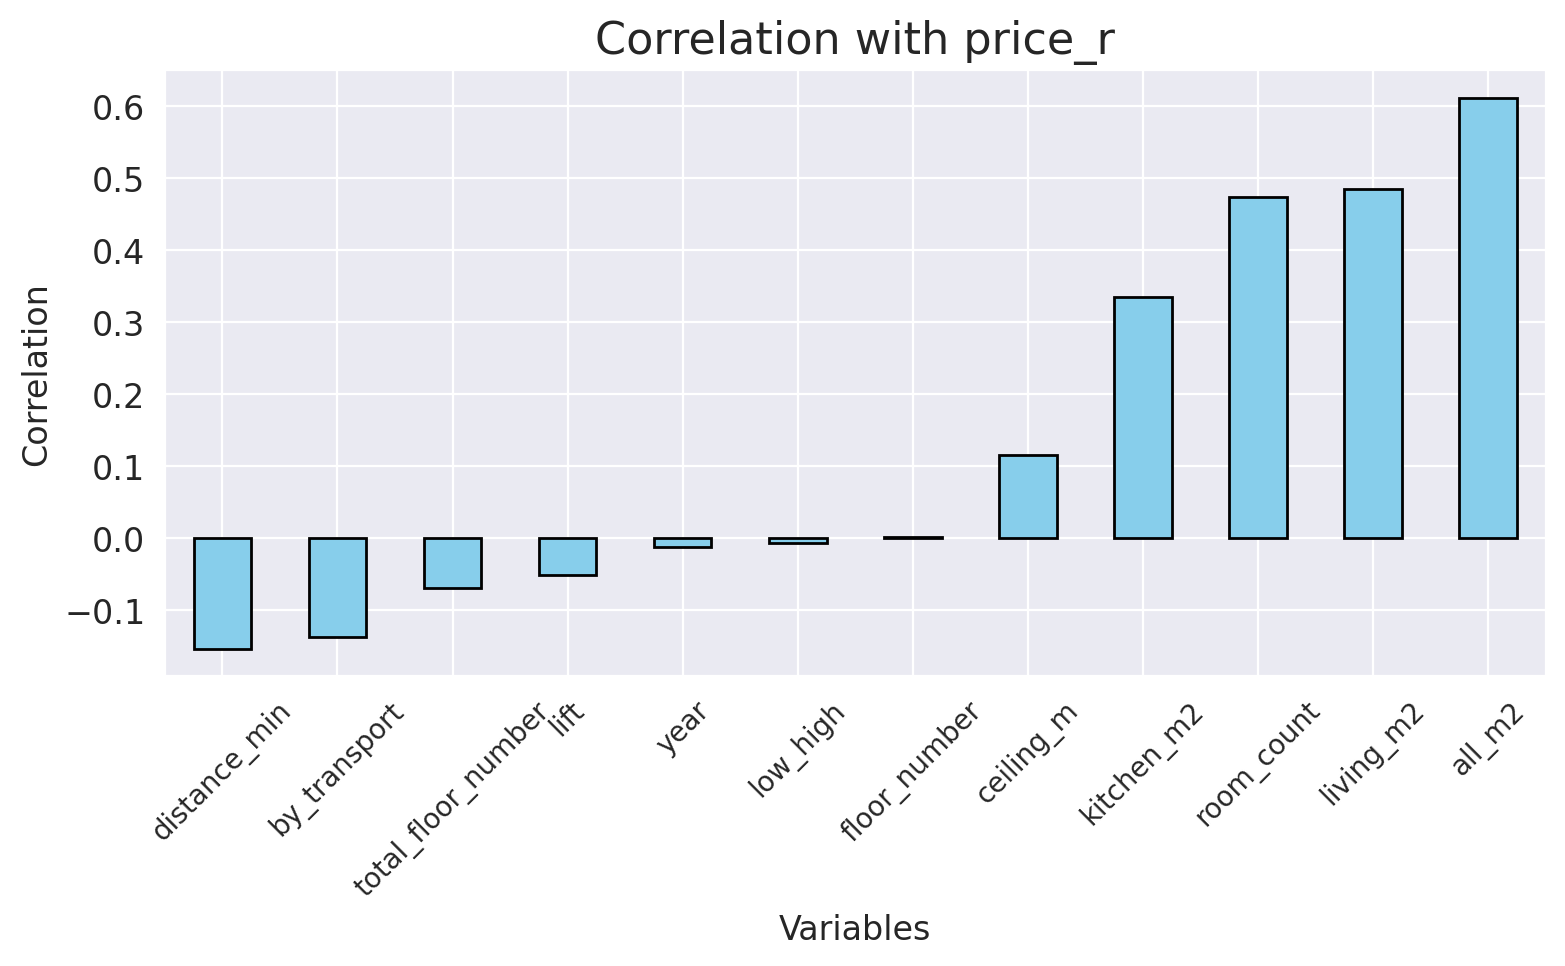

In [ ]:
correlations = df_num_features.corr()['price_r'].drop('price_r')

# Step 2: Plot the correlations
plt.figure(figsize=(8, 5))
correlations.sort_values().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Correlation with price_r', fontsize=16)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

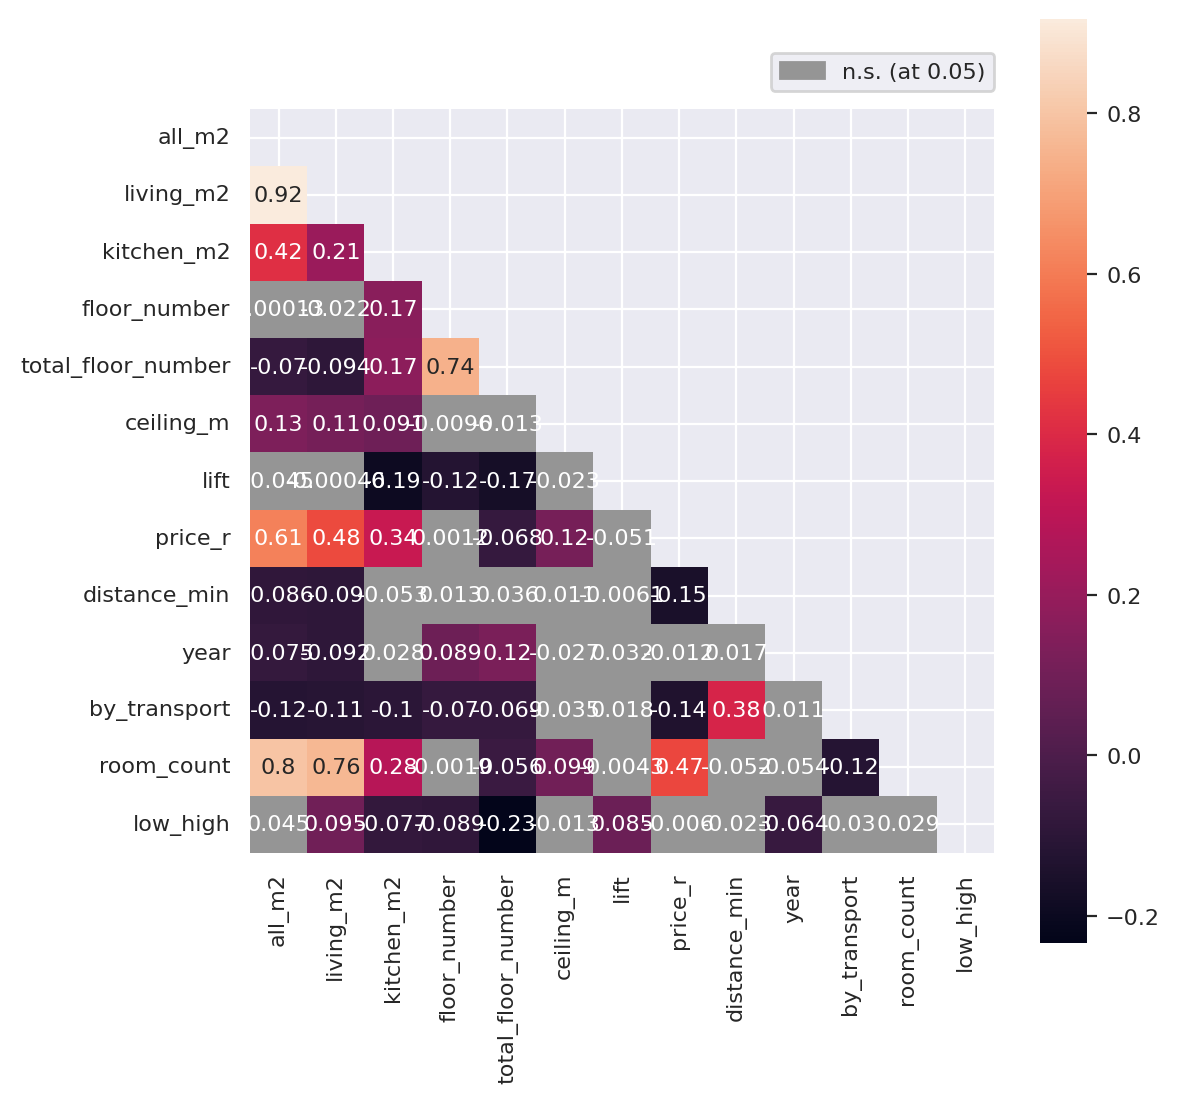

In [ ]:
#!check why ceilig_m became only 3.

from scipy.stats import pearsonr
import matplotlib.patches as mpatches

plt.rcParams['font.size'] = 8

# get the p value for pearson coefficient, subtract 1 on the diagonal
pvals = df_num_features.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*df_num_features.corr().shape)

# set the significance threshold
psig = 0.05

plt.figure(figsize=(6,6))

mask = np.zeros_like(df_num_features.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_num_features.corr()[pvals<psig], annot=True, square=True, mask = mask)

# add another heatmap with colouring the non-significant cells
sns.heatmap(df_num_features.corr()[pvals>=psig], annot=True, square=True, cbar=False,
            cmap=sns.color_palette("Greys", n_colors=1, desat=1), mask = mask)



# add a label for the colour
colors = [sns.color_palette("Greys", n_colors=1, desat=1)[0]]
texts = [f"n.s. (at {psig})"] #adding the significance value
patches = [mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts))]
plt.legend(handles=patches, bbox_to_anchor=(.85, 1.05), loc='center')